In [1]:
# !pip3 install pandas numpy matplotlib seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import scipy
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
sns.set()

# Preprocess

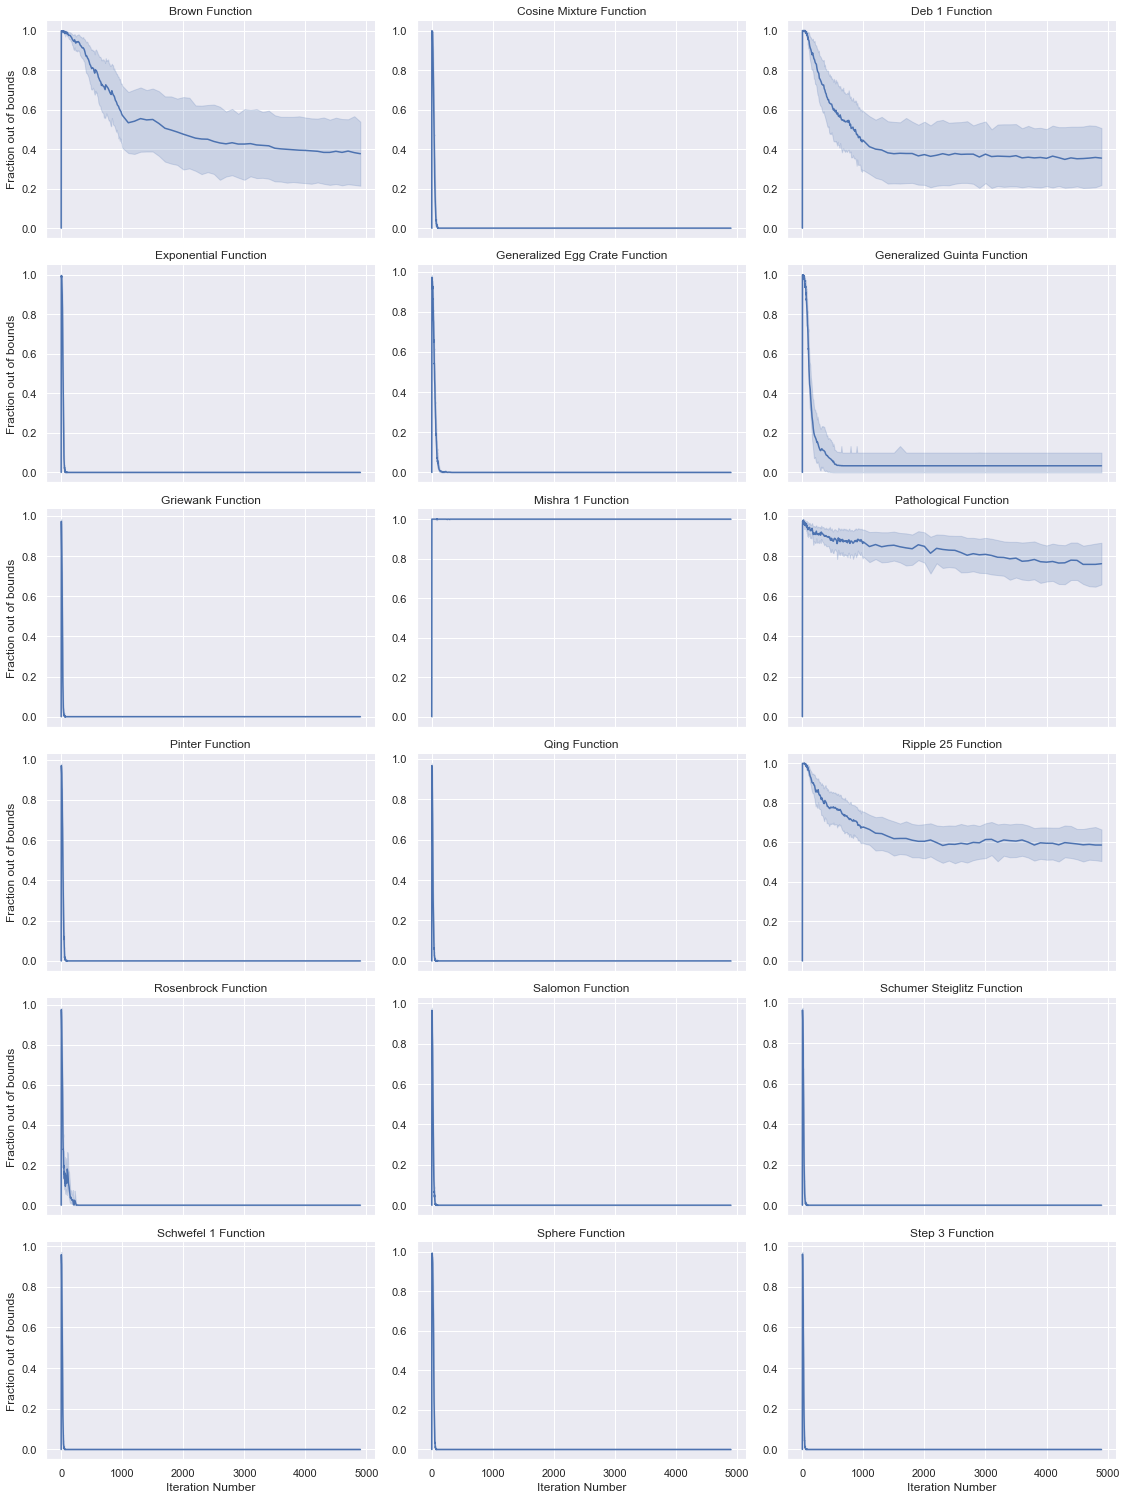

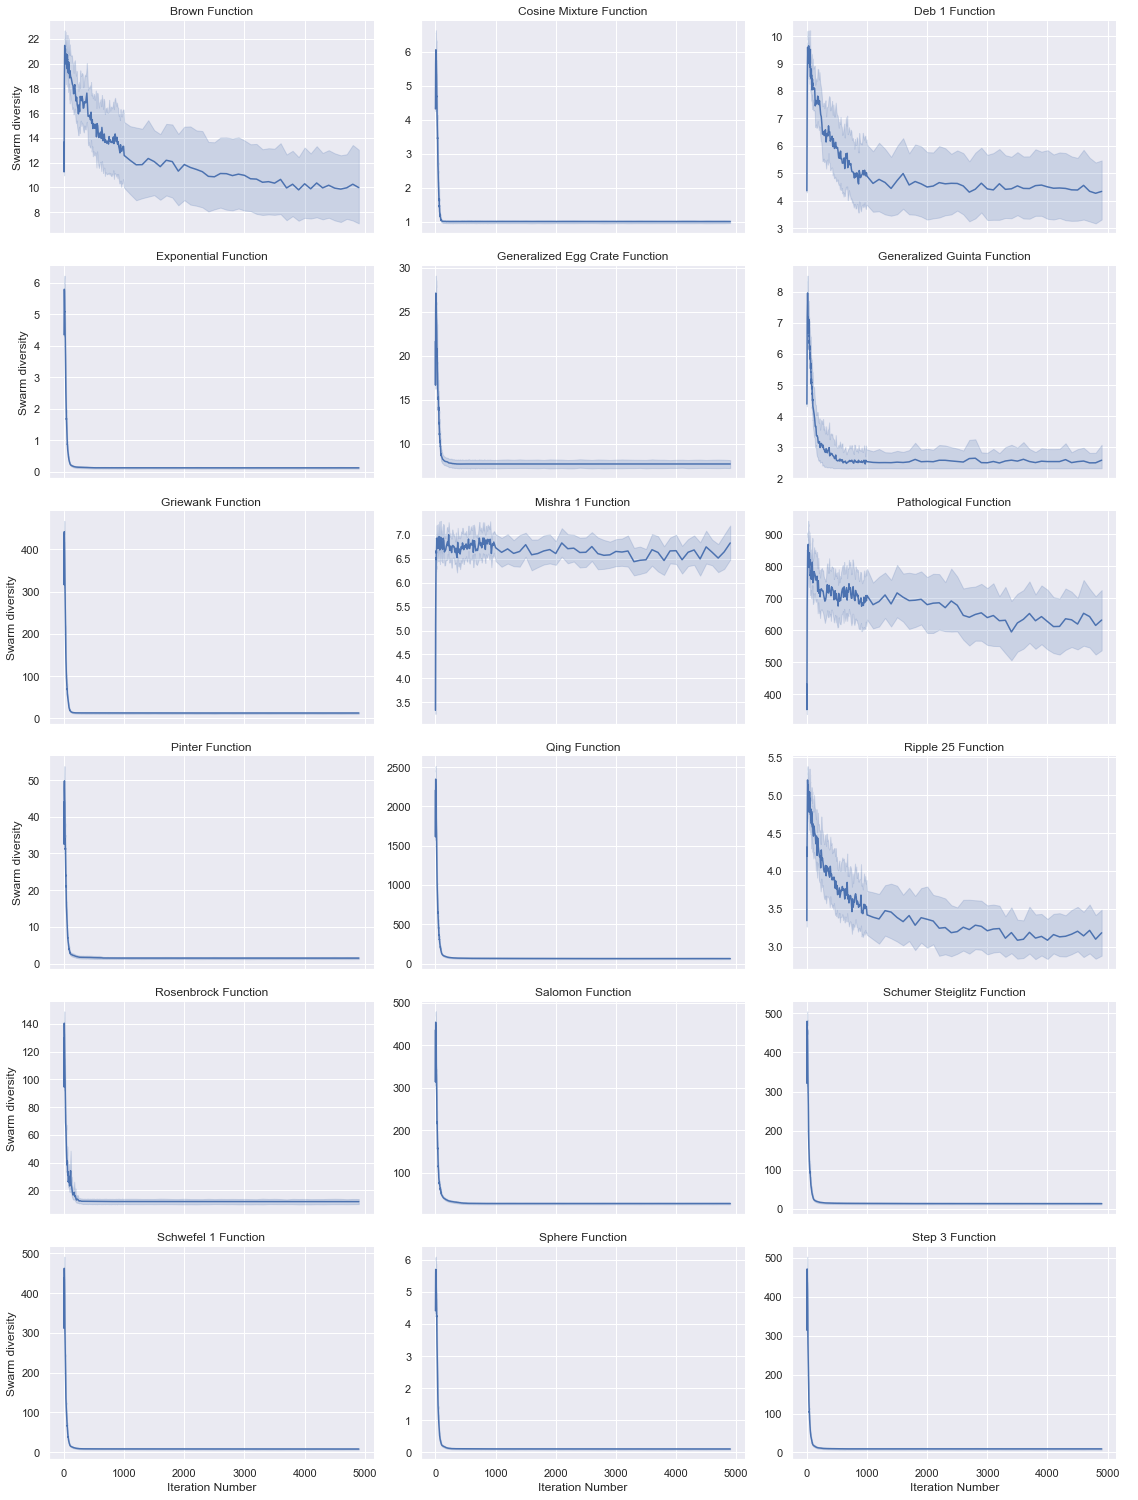

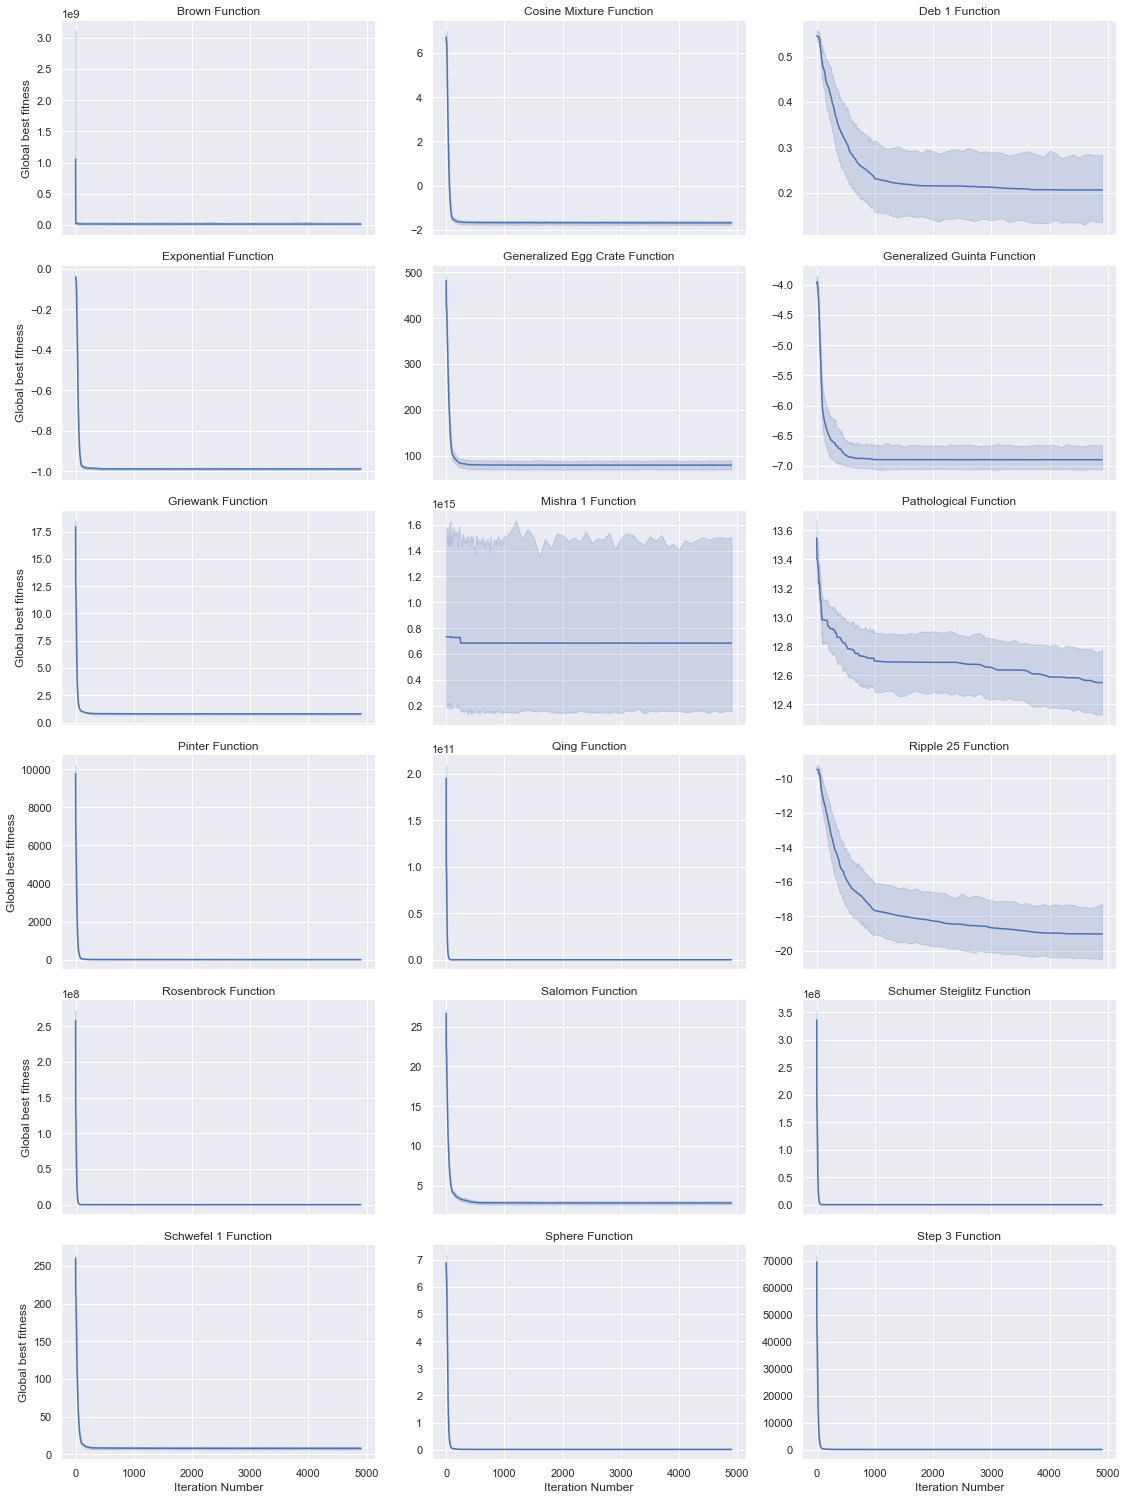

CPU times: user 1min 20s, sys: 623 ms, total: 1min 21s
Wall time: 1min 19s


In [3]:
%%time
# CPU times: user 28 s, sys: 146 ms, total: 28.1 s
# Wall time: 27.6 s

# stdpso = pd.read_csv(f'data/raw/std_pso_{datetime.date.today()}.csv').sort_values('benchmark')
stdpso = pd.read_csv(f'data/raw/std_pso_2022-03-20.csv').sort_values('benchmark')

prefs = [
    {
        'key': 'perc_oob',
        'in_parens': 'Fraction out of bounds',
        'save_as': 'standard_pso_perc_oob',
    }, {
        'key': 'gdiversity',
        'in_parens': 'Swarm diversity',
        'save_as': 'standard_pso_gdiversity',
    }, {
        'key': 'gbest_fit',
        'in_parens': 'Global best fitness',
        'save_as': 'standard_pso_gbest_fit',
    },
]
pref = prefs[2]
for pref in prefs:

    g = sns.FacetGrid(
        data=stdpso,
        col="benchmark", 
        col_wrap=3,
        height=3.5, 
        aspect=1.5,
        sharey=False,
        palette="viridis",
    )

    g.map_dataframe(
        sns.lineplot,
        x="iter_num",
        y=pref['key'],
    #     estimator=None,
    #     units='rep_num',
    #     ci=None
    )
    g.add_legend()
    g.set_titles(
        col_template="{col_name}", 
    #     row_template="{row_name}"
    )

    g.set_axis_labels("Iteration Number", pref['in_parens'])
#     plt.savefig(f"../report/figs/{pref['save_as']}.pdf")
    plt.show()

# Optimise Control Parameters per Benchmark

## Heatmaps of Control Params

In [96]:
# min_per_bench = opt_gb.groupby('benchmark').gbest_fit.min()
# rng_per_bench = opt_gb.groupby('benchmark').gbest_fit.max() - min_per_bench
# rng_per_bench
sorted(opt.benchmark.unique())

['Cosine Mixture Function',
 'Deb 1 Function',
 'Deb 3 Function',
 'Exponential Function',
 'Generalized Egg Crate Function',
 'Generalized Guinta Function',
 'Generalized Paviani Function',
 'Generalized Price 2 Function',
 'Griewank Function',
 'Mishra 1 Function',
 'Pathological Function',
 'Pinter Function',
 'Qing Function',
 'Ripple 25 Function',
 'Rosenbrock Function',
 'Salomon Function',
 'Schumer Steiglitz Function',
 'Schwefel 1 Function',
 'Sphere Function',
 'Step 3 Function']

In [4]:
%%time
use_old_files = True
# CPU times: user 31.9 s, sys: 10.8 s, total: 42.8 s
# Wall time: 46.1 s


prefs = [
#     {
#         'key': 'perc_oob',
#         'in_parens': 'Fraction out of bounds',
#         'save_as': 'opt_heatmaps_perc_oob',
#     }, {
#         'key': 'gdiversity',
#         'in_parens': 'Swarm diversity',
#         'save_as': 'opt_heatmaps_gdiversity',
#     }, {
#         'key': 'log_diversity',
#         'in_parens': '$\log_{{10}}$ of swarm diversity',
#         'save_as': 'opt_heatmaps_log_diversity',
#     }, 
    {
        'key': 'gbest_fit',
        'in_parens': 'Global best fitness',
        'save_as': 'opt_heatmaps_gbest_fit',
    },
]
# pref = prefs[2]

VAL = 'gbest_std'

pp_df_path = 'data/opt.csv'
for pref in prefs:
#     if False and os.path.exists(pp_df_path):
#         opt_gb = pd.read_csv(pp_df_path)
#     else:
    files = [
        'data/raw/opt_2022-05-28_rep_0.csv',
        'data/raw/opt_2022-05-28_rep_1.csv',
        'data/raw/opt_2022-05-28_rep_2.csv',
        'data/raw/opt_2022-05-28_rep_3.csv',
        'data/raw/opt_2022-05-28_rep_4.csv',
        'data/raw/opt_2022-05-29_rep_0.csv',
        'data/raw/opt_2022-05-29_rep_1.csv',
        'data/raw/opt_2022-05-29_rep_2.csv',
        'data/raw/opt_2022-05-29_rep_3.csv',
        'data/raw/opt_2022-05-29_rep_4.csv',
    ] 
    dfs = []
    
    for i, file in enumerate(files, 1):
        df = pd.read_csv(file)
        df['rep'] = i
        df = df[~df.benchmark.isin([
            'Generalized Paviani Function', 
            'Deb 3 Function',
            'Generalized Price 2 Function',
            'Mishra 1 Function',
            'Exponential Function'
        ])]
        df = df[df['w'].between(-1.0, 1.0)]
        dfs.append(df)
    opt = pd.concat(dfs)

    opt['c'] = np.round(opt['c1'] + opt['c2'], 4)
    opt['w'] = np.round(opt['w'], 4)
    opt['log_diversity'] = np.log10(opt['gdiversity'])
    opt_gb = opt[opt.iter_num == opt.iter_num.max()].groupby(['benchmark', 'w', 'c'])[pref['key']] \
                .mean() \
                .reset_index() \
                .sort_values('benchmark')
    min_per_bench = opt_gb.groupby('benchmark').gbest_fit.min()
    rng_per_bench = opt_gb.groupby('benchmark').gbest_fit.max() - min_per_bench
    opt_gb['gbest_std'] = opt_gb.apply(
        lambda row: (row['gbest_fit'] - min_per_bench[row['benchmark']]) / rng_per_bench[row['benchmark']],
        axis=1
    )
    opt_gb.to_csv(pp_df_path)
        
#     break
    w = np.arange(-1.1, 1.1, 0.05)
    c = (24 * (1 - w*w)) / (7 - 5 * (-w))
    x_offset = 0
    x_factor = 9.75
    y_offset = 10.5
    y_factor = 10
    def draw_heatmap(*args, **kwargs):
        data = kwargs.pop('data')
        d = data.pivot(columns=args[0], index=args[1], values=args[2])
        d = d.reindex(index=sorted(d.index)[::-1])
        d = d.reindex(columns=sorted(d.columns))
        ax = sns.heatmap(d, **kwargs)
#         plt.plot(
#             (c  * x_factor) + x_offset, 
#             (w  * y_factor) + y_offset, 
#             c='white'
#         )

    g = sns.FacetGrid(opt_gb,
                      col='benchmark', 
                      col_wrap=3, 
                      height=4,
                      aspect=1.9
                     )

    g.map_dataframe(draw_heatmap, 'c', 'w', VAL,
                    cmap="viridis",
                    yticklabels=True, 
                    xticklabels=True)

    g.set_titles(
        col_template=f"{{col_name}} ({VAL})", 
    )
    g.set_axis_labels("$c=c_1+c_2$", "$w$")

#     plt.savefig(f"../report/figs/{pref['save_as']}.pdf")
#     plt.savefig(f"../../../assignment3/report/imgs/heatmaps.pdf")
    
    plt.show()

KeyboardInterrupt: 

In [3]:
opt_gb = pd.read_csv('data/opt.csv')

In [5]:
%matplotlib
d = opt_gb[opt_gb.benchmark == 'Schwefel 1 Function'].pivot(columns='c', index='w', values='gbest_fit')
shp = d.shape
xx = np.tile(d.index.to_numpy(), (shp[1], 1)).T
yy = np.tile(d.columns.to_numpy(), (shp[0], 1))
zz = d.values
xx.shape, yy.shape, zz.shape
# ax = plt.figure().add_subplot(projection='3d')

# ax.plot_surface(xx, yy, zz, cmap='autumn')
# plt.show()

Using matplotlib backend: <object object at 0x130da1240>


((21, 51), (21, 51), (21, 51))

In [6]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot_surface(xx, yy, zz, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)
plt.show()

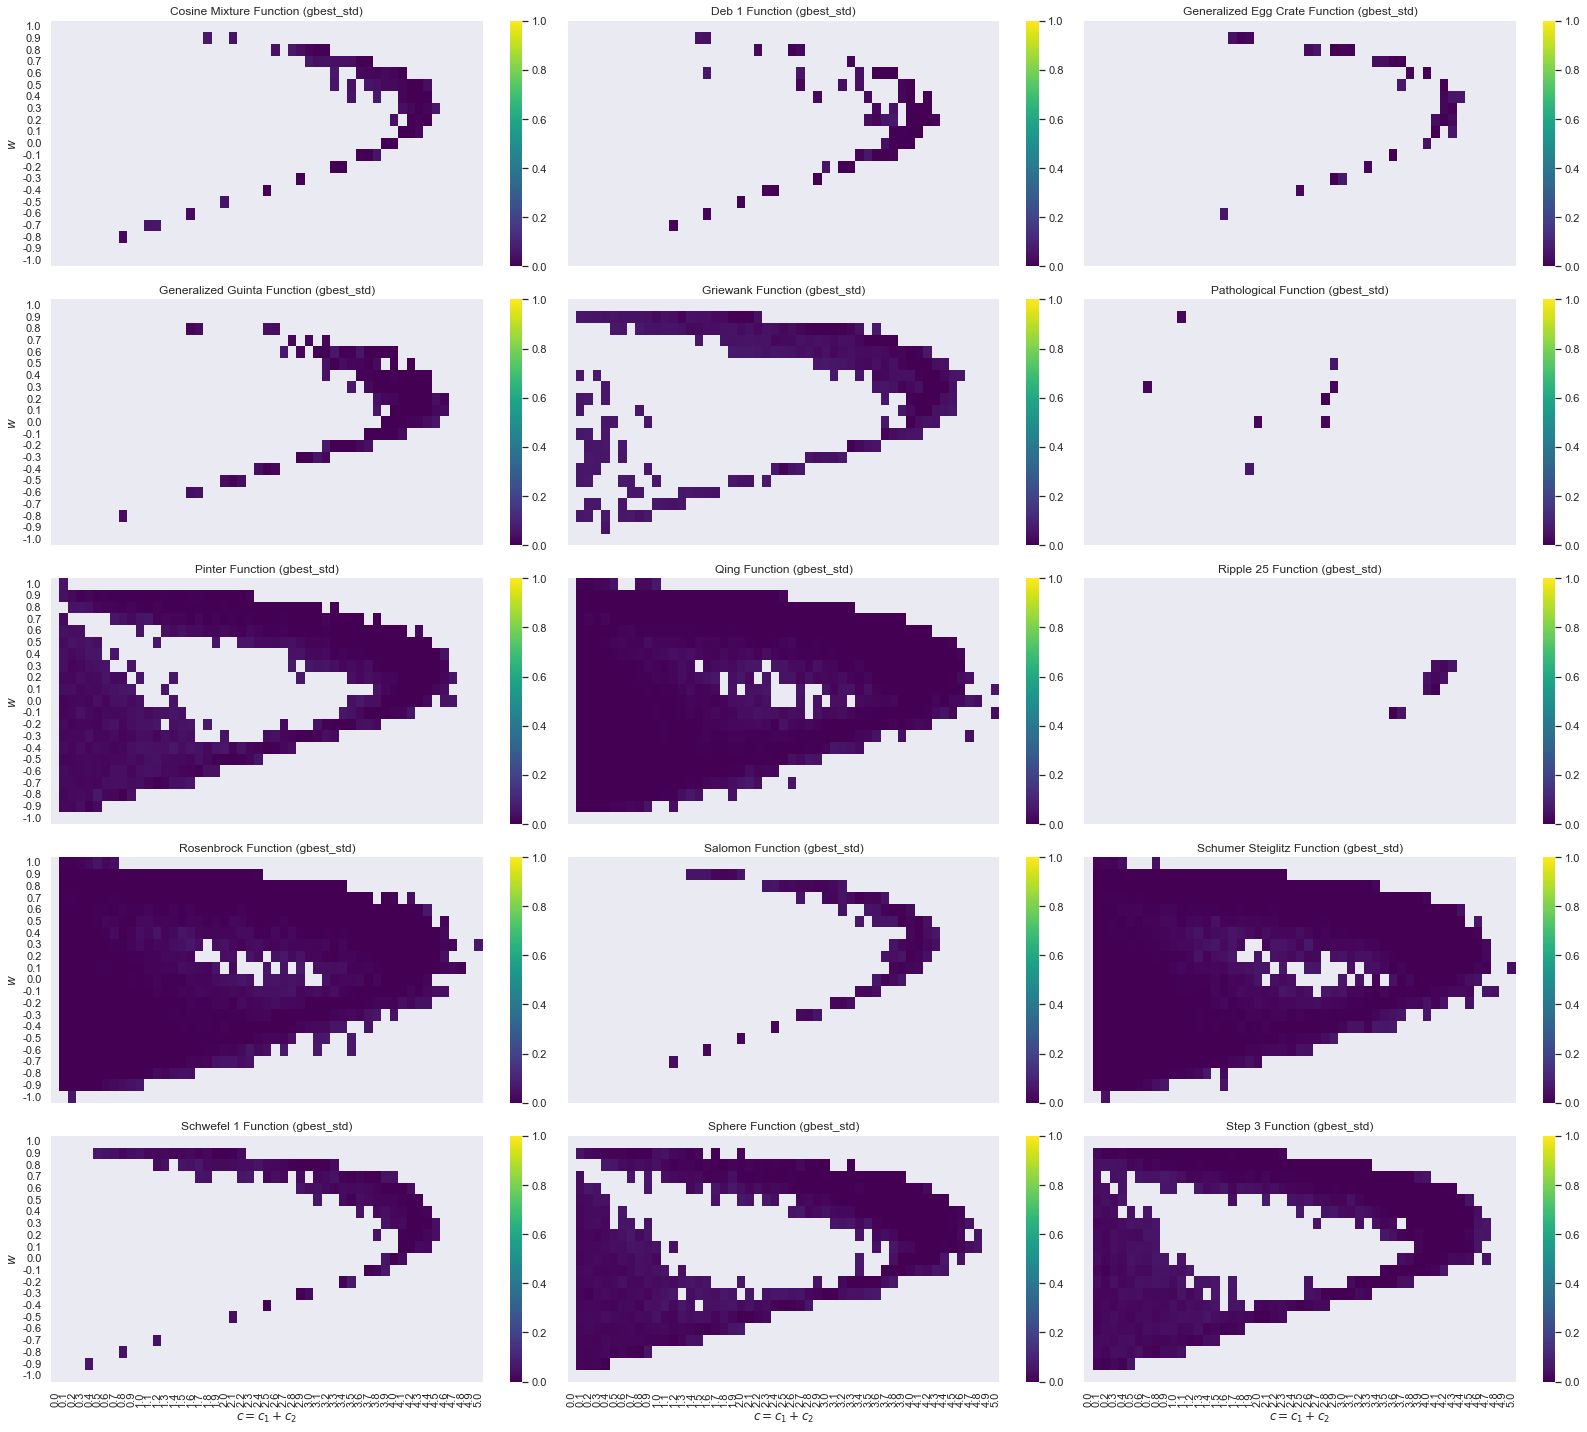

CPU times: user 7.98 s, sys: 290 ms, total: 8.27 s
Wall time: 7.72 s


In [206]:
%%time

VAL = 'gbest_std'

pp_df_path = 'data/opt.csv'
# for pref in prefs:
# if False and os.path.exists(pp_df_path):
opt_gb = pd.read_csv(pp_df_path)
# else:
#     opt = pd.read_csv(f'data/raw/opt_2022-05-28_rep_0.csv')
# opt_gb = opt_gb[opt.benchmark.isin([
#     'Cosine Mixture Function', 
#     'Pathological Function', 
#     'Schwefel 1 Function', 
# ])]
#     opt = opt[opt['w'].between(-1.0, 1.0)]

#     opt['c'] = np.round(opt['c1'] + opt['c2'], 4)
#     opt['w'] = np.round(opt['w'], 4)
#     opt['log_diversity'] = np.log10(opt['gdiversity'])
#     opt_gb = opt[opt.iter_num == 3900].groupby(['benchmark', 'w', 'c'])[pref['key']] \
#                 .mean() \
#                 .reset_index() \
#                 .sort_values('benchmark')
#     min_per_bench = opt_gb.groupby('benchmark').gbest_fit.min()
#     rng_per_bench = opt_gb.groupby('benchmark').gbest_fit.max() - min_per_bench
#     opt_gb['gbest_std'] = opt_gb.apply(
#         lambda row: (row['gbest_fit'] - min_per_bench[row['benchmark']]) / rng_per_bench[row['benchmark']],
#         axis=1
#     )
#     opt_gb.to_csv(pp_df_path)
q=0.25
gbest_std_quant = opt_gb.gbest_std.quantile(q)
opt_gb['gbest_std'] = opt_gb.apply(
    lambda row: row.gbest_std if row.gbest_std < gbest_std_quant else np.nan, 
    axis=1
)

# opt_gb[opt_gb.gbest_std < opt_gb.gbest_std.quantile(0.5)]

w = np.arange(-1.0, 1.0, 0.05)
c = (24 * (1 - w*w)) / (7 - 5 * (-w))
x_offset = 0
x_factor = 9.75
y_offset = 10.5
y_factor = 10
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(columns=args[0], index=args[1], values=args[2])
    d = d.reindex(index=sorted(d.index)[::-1])
    d = d.reindex(columns=sorted(d.columns))
    ax = sns.heatmap(d, **kwargs)
#     plt.plot(
#         (c  * x_factor) + x_offset, 
#         (w  * y_factor) + y_offset, 
#         c='white'
#     )

g = sns.FacetGrid(
    opt_gb,
    col='benchmark', 
    col_wrap=3, 
    height=4,
    aspect=1.9
)

g.map_dataframe(
    draw_heatmap, 'c', 'w', VAL,
    cmap="viridis",
    yticklabels=True, 
    xticklabels=True,
    vmin=0.0,
    vmax=1.0,
#     square=True
)

g.set_titles(
    col_template=f"{{col_name}} ({VAL})", 
)
g.set_axis_labels("$c=c_1+c_2$", "$w$")
plt.savefig(f"../../../assignment3/report/imgs/thresh_{q}.pdf")

# plt.savefig(f"../report/figs/{pref['save_as']}.pdf")
plt.show()

In [212]:
pp_df_path = 'data/opt.csv'

opt_gb = pd.read_csv(pp_df_path)

@interact(q=(0, 1, 0.01))
def widget(q=0.25):
    opt_gb = pd.read_csv(pp_df_path)
    gbest_std_quant = opt_gb.gbest_std.quantile(q)
    opt_gb['gbest_std'] = opt_gb.apply(
        lambda row: row.gbest_std if row.gbest_std < gbest_std_quant else 1.0, 
        axis=1
    )
    opt_gb = opt_gb.groupby(['w', 'c']).gbest_std.sum().reset_index()
    opt_gb['gbest_std'] = opt_gb['gbest_std'].max() - opt_gb['gbest_std']
    opt_gb['gbest_std'] /=  opt_gb.gbest_std.sum()
    d = opt_gb.pivot(columns='c', index='w', values='gbest_std')
    d = d.reindex(index=sorted(d.index)[::-1])
    d = d.reindex(columns=sorted(d.columns))
    ax = sns.heatmap(d, vmin=0, square=True, cbar=False, cmap='viridis')
#     print("return vec![")
#     for i, row in opt_gb.iterrows():
#         if row.gbest_std > 0:
#             print(f"    ( ControlParams {{ w: {row.w}, c1: {row.c}, c2: {row.c} }}, {row.gbest_std} ),")
#     print("];")
#     plt.tight_layout()
    plt.savefig(f"../../../assignment3/report/imgs/quantile{q}.pdf", bbox_inches='tight')



interactive(children=(FloatSlider(value=0.25, description='q', max=1.0, step=0.01), Output()), _dom_classes=('…

In [242]:
df

benchmark                           strat  gbest_fit
0   Cosine Mixture Function          EmpiricallyTuned(0.12)   -2.87320
1   Cosine Mixture Function          EmpiricallyTuned(0.25)   -2.89880
2   Cosine Mixture Function           EmpiricallyTuned(0.5)   -2.88962
3   Cosine Mixture Function           EmpiricallyTuned(1.0)   -2.92852
4   Cosine Mixture Function  RandomAccelerationCoefficients   -2.86436
..                      ...                             ...        ...
72          Step 3 Function           EmpiricallyTuned(0.5)    0.00000
73          Step 3 Function           EmpiricallyTuned(1.0)    0.00000
70          Step 3 Function          EmpiricallyTuned(0.12)    0.00000
71          Step 3 Function          EmpiricallyTuned(0.25)    0.20000
74          Step 3 Function  RandomAccelerationCoefficients    0.20000

[75 rows x 3 columns]

In [256]:
df = pd.read_csv('data/raw/et_pso_2022-05-29_rep_4.csv')
df['rep'] = i
df = df[~df.benchmark.isin([
    'Generalized Paviani Function', 
    'Deb 3 Function',
    'Generalized Price 2 Function',
    'Mishra 1 Function',
    'Exponential Function'
])]
df = df[df['w'].between(-1.0, 1.0)]
df = df[df['iter_num'] > 0]
df = pd.concat([df])
df['log10_iter_num'] = np.log10(df['iter_num'])

df = df.groupby(['benchmark', 'strat', 'log10_iter_num'])['gbest_fit'] \
    .mean() \
    .reset_index() \
    .sort_values('benchmark')

df

benchmark                           strat  \
0      Cosine Mixture Function          EmpiricallyTuned(0.12)   
721    Cosine Mixture Function           EmpiricallyTuned(1.0)   
722    Cosine Mixture Function           EmpiricallyTuned(1.0)   
723    Cosine Mixture Function           EmpiricallyTuned(1.0)   
724    Cosine Mixture Function           EmpiricallyTuned(1.0)   
...                        ...                             ...   
15692          Step 3 Function          EmpiricallyTuned(0.25)   
15691          Step 3 Function          EmpiricallyTuned(0.25)   
15690          Step 3 Function          EmpiricallyTuned(0.25)   
15696          Step 3 Function          EmpiricallyTuned(0.25)   
16424          Step 3 Function  RandomAccelerationCoefficients   

       log10_iter_num  gbest_fit  
0            0.000000     3.8954  
721          1.812913    -1.3709  
722          1.819544    -1.3738  
723          1.826075    -1.4011  
724          1.832509    -1.4358  
...               ...        ...  
15692        2.732394   198.0000  
15691        2.724276   203.0000  
15690        2.716003   205.0000  
15696        2.763428   193.0000  
16424        3.591065     0.0000  

[16425 rows x 4 columns]

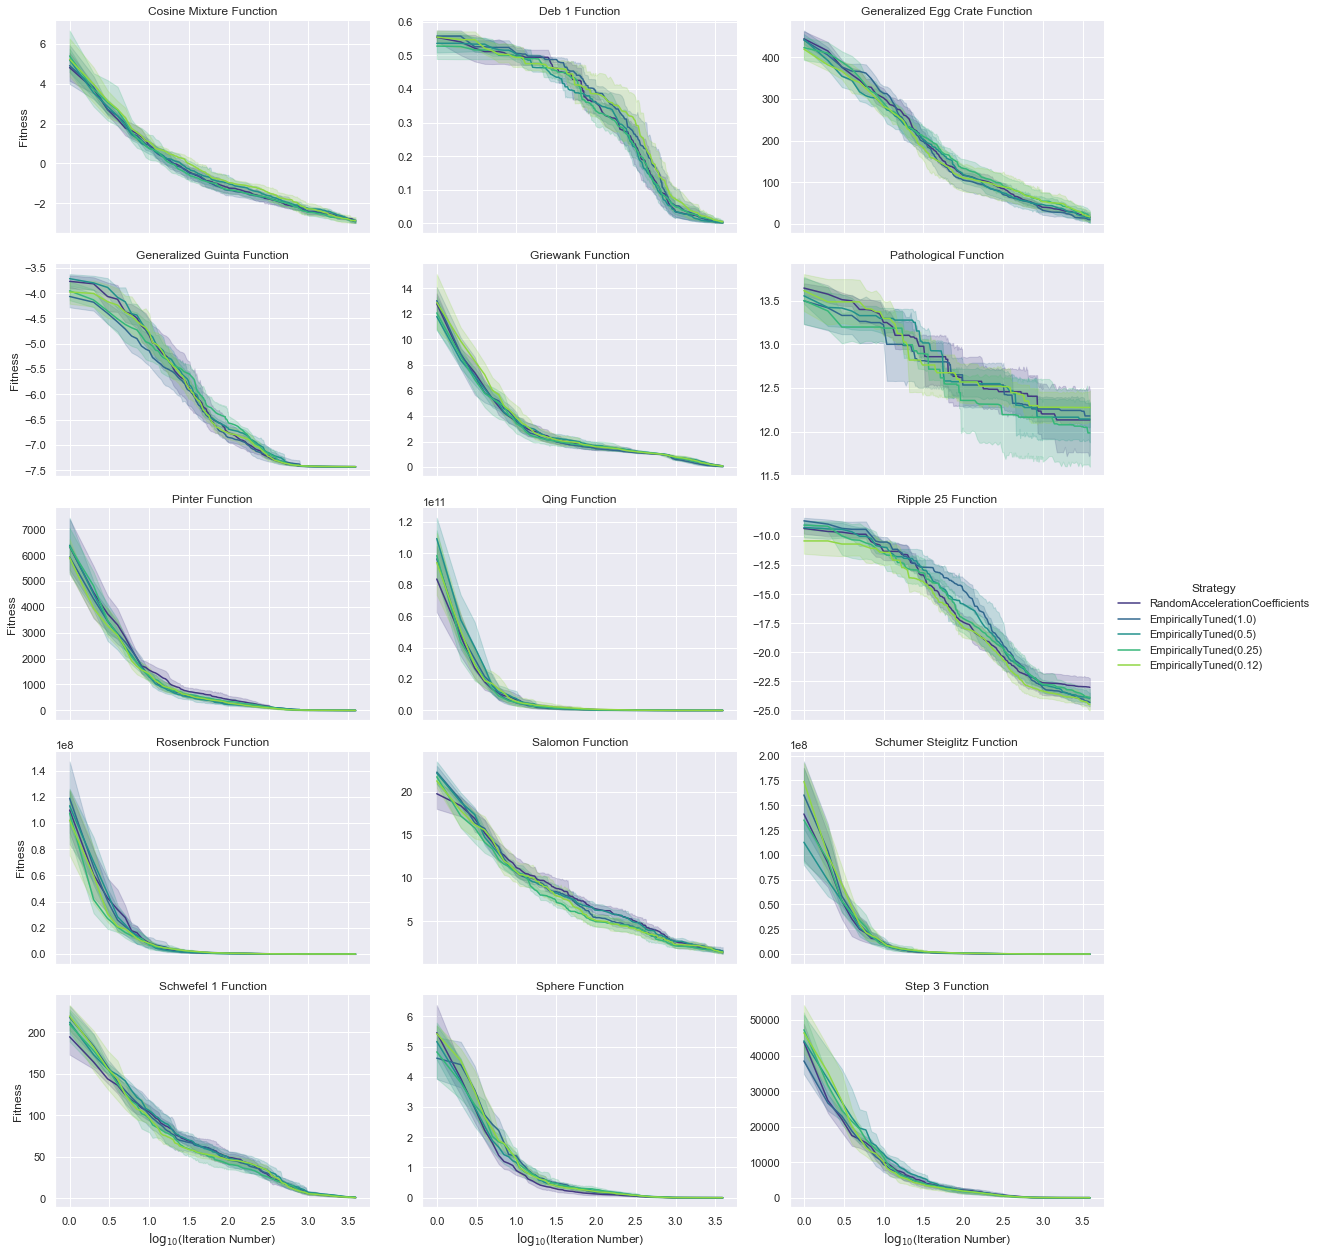

In [286]:
# df = pd.read_csv('data/raw/et_pso_2022-05-29_rep_0.csv')
# df['strat'] = df.apply(lambda row: 'PSO-RAC' if row['max_stagnent_iters'] == 1 else 'ET-PSO', axis=1)
files = [
    'data/raw/et_pso_2022-05-29_rep_4.csv',
    'data/raw/et_pso_2022-05-29_rep_3.csv',
    'data/raw/et_pso_2022-05-29_rep_2.csv',
    'data/raw/et_pso_2022-05-29_rep_1.csv',
    'data/raw/et_pso_2022-05-29_rep_0.csv',
] 
dfs = []

for i, file in enumerate(files, 1):
    df = pd.read_csv(file)
    df['rep_num'] = i
    df = df[~df.benchmark.isin([
        'Generalized Paviani Function', 
        'Deb 3 Function',
        'Generalized Price 2 Function',
        'Mishra 1 Function',
        'Exponential Function'
    ])]
    df = df[df['w'].between(-1.0, 1.0)]
    df = df[df['iter_num'] > 0]
    df['log10_iter_num'] = np.log10(df['iter_num'])
    df = df[['benchmark','log10_iter_num', 'rep_num', 'gbest_fit', 'strat']]
    dfs.append(df)
    
df = pd.concat(dfs).reset_index()

g = sns.FacetGrid(
    data=df,
    col="benchmark", 
    hue='strat',
    col_wrap=3,
    height=3.5, 
    aspect=1.5,
    sharey=False,
    col_order=np.sort(df.benchmark.unique()),
    palette="viridis",
)

g.map_dataframe(
    sns.lineplot,
    x="log10_iter_num",
    y='gbest_fit',
#     units="rep"
)
g.add_legend(title='Strategy')
g.set_titles(
    col_template="{col_name}", 
#     row_template="{row_name}"
)

g.set_axis_labels("$\log_{10}$(Iteration Number)", 'Fitness')
plt.savefig(f"../../../assignment3/report/imgs/strategies.pdf")
plt.show()


benchmark  log10_iter_num  rep_num  gbest_fit  \
1              Pinter Function        0.000000        1  4650.5000   
2              Pinter Function        0.301030        1  3461.4000   
3              Pinter Function        0.477121        1  2816.8000   
4              Pinter Function        0.602060        1  2501.7000   
5              Pinter Function        0.698970        1  2314.8000   
...                        ...             ...      ...        ...   
21995  Cosine Mixture Function        3.544068        5    -2.8207   
21996  Cosine Mixture Function        3.556303        5    -2.8232   
21997  Cosine Mixture Function        3.568202        5    -2.8343   
21998  Cosine Mixture Function        3.579784        5    -2.8346   
21999  Cosine Mixture Function        3.591065        5    -2.8392   

                                strat  
1      RandomAccelerationCoefficients  
2      RandomAccelerationCoefficients  
3      RandomAccelerationCoefficients  
4      RandomAccelerationCoefficients  
5      RandomAccelerationCoefficients  
...                               ...  
21995          EmpiricallyTuned(0.12)  
21996          EmpiricallyTuned(0.12)  
21997          EmpiricallyTuned(0.12)  
21998          EmpiricallyTuned(0.12)  
21999          EmpiricallyTuned(0.12)  

[82125 rows x 5 columns]

<AxesSubplot:xlabel='log10_iter_num', ylabel='gbest_fit'>

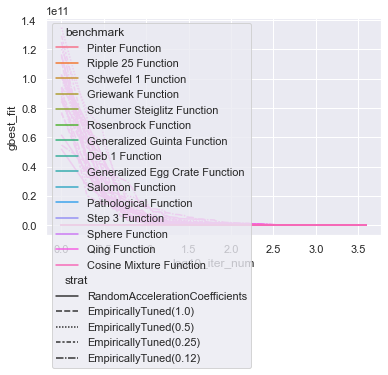

In [284]:
sns.lineplot(
    data=df.reset_index(),
    x='log10_iter_num',
    y='gbest_fit',
    hue='benchmark',
    style='strat',
    units="rep_num",
    estimator=None,
)

In [236]:
df = pd.read_csv('data/raw/et_pso_2022-05-29_rep_0.csv')
# df['strat'] = df.apply(lambda row: 'PSO-RAC' if row['max_stagnent_iters'] == 1 else 'ET-PSO', axis=1)

df = df[df['iter_num'] == df['iter_num'].max()]
# df['log10_iter_num'] = np.log10(df['iter_num'])

df = df[~df.benchmark.isin([
    'Generalized Paviani Function', 
    'Deb 3 Function',
    'Generalized Price 2 Function',
    'Mishra 1 Function',
    'Exponential Function'
])]

values = df.groupby(['benchmark', 'strat'])['gbest_fit'] \
            .max() \
            .reset_index() \
            .pivot(columns='strat', index='benchmark', values='gbest_fit')
with open(f"../../../assignment3/report/table.tex", 'w') as f:
    tex = values.to_latex(
        caption='Optimal strategies',
        label="tab:best_strat"
    )
    f.write(tex.replace(" Function", '') \
          .replace('benchmark', 'Benchmark Function') \
          .replace('strat', 'PSO Variant')
          .replace('EmpiricallyTuned', 'ET-PSO')
          .replace('RandomAccelerationCoefficients', 'PSO-RAC')
     )
values

/var/folders/y1/md9_k_td4rz1f0pq26d24crh0000gn/T/ipykernel_19451/2979031387.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex = values.to_latex(


strat                           EmpiricallyTuned(0.12)  \
benchmark                                                
Cosine Mixture Function                      -2.839200   
Deb 1 Function                                0.003213   
Generalized Egg Crate Function               10.021000   
Generalized Guinta Function                  -7.432700   
Griewank Function                             0.087536   
Pathological Function                        12.531000   
Pinter Function                              -2.806300   
Qing Function                             64490.000000   
Ripple 25 Function                          -24.899000   
Rosenbrock Function                          28.835000   
Salomon Function                              1.500100   
Schumer Steiglitz Function                   11.779000   
Schwefel 1 Function                           0.666070   
Sphere Function                               0.000073   
Step 3 Function                               0.000000   

strat                           EmpiricallyTuned(0.25)  EmpiricallyTuned(0.5)  \
benchmark                                                                       
Cosine Mixture Function                      -2.843300              -2.961900   
Deb 1 Function                                0.013115               0.001517   
Generalized Egg Crate Function                1.957700               0.167400   
Generalized Guinta Function                  -7.432800              -7.432600   
Griewank Function                             0.098090               0.057204   
Pathological Function                        12.400000              12.493000   
Pinter Function                              -2.755400              -2.224100   
Qing Function                              2974.300000            5872.700000   
Ripple 25 Function                          -24.353000             -24.223000   
Rosenbrock Function                          31.357000              31.598000   
Salomon Function                              1.200300               1.402400   
Schumer Steiglitz Function                    9.507100               3.452600   
Schwefel 1 Function                           1.375200               1.565600   
Sphere Function                               0.000110               0.000134   
Step 3 Function                               1.000000               0.000000   

strat                           EmpiricallyTuned(1.0)  \
benchmark                                               
Cosine Mixture Function                     -2.898000   
Deb 1 Function                               0.000908   
Generalized Egg Crate Function               0.915850   
Generalized Guinta Function                 -7.432800   
Griewank Function                            0.049431   
Pathological Function                       12.044000   
Pinter Function                             -2.746700   
Qing Function                             6691.800000   
Ripple 25 Function                         -24.097000   
Rosenbrock Function                         25.783000   
Salomon Function                             1.031600   
Schumer Steiglitz Function                  53.562000   
Schwefel 1 Function                          0.651650   
Sphere Function                              0.000130   
Step 3 Function                              0.000000   

strat                           RandomAccelerationCoefficients  
benchmark                                                       
Cosine Mixture Function                              -2.846600  
Deb 1 Function                                        0.011906  
Generalized Egg Crate Function                       28.470000  
Generalized Guinta Function                          -7.432800  
Griewank Function                                     0.066130  
Pathological Function                                12.054000  
Pinter Function                                      -2.461300  
Qing Function                                     28312.000000  
Ripple 25 Funct

## Calculate the latex table

In [6]:
opt = pd.read_csv(f'data/raw/opt_2022-03-20.csv')
opt = opt[~opt.benchmark.isin([
    'Deb 3 Function',
    'Generalized Price 2 Function',
    'Mishra 7 Function',
    'Generalized Paviani Function',
])]

opt['c'] = np.round(opt['c1'] + opt['c2'], 4)
opt['w'] = np.round(opt['w'], 4)

opt_gb = opt[opt.iter_num == 4900].groupby(['benchmark', 'w', 'c'])['gbest_fit'] \
            .mean() \
            .reset_index() \
            .sort_values('benchmark')
    
opt_gb['1%'] = opt_gb.groupby('benchmark').gbest_fit.transform(lambda x: x.quantile(0.01))
best_cps = opt_gb[opt_gb.gbest_fit < opt_gb['1%']] \
    .sort_values(['benchmark', 'gbest_fit', 'w', 'c']) \
    .set_index(['benchmark', 'w', 'c'])[['gbest_fit']]
best_cps['gbest_fit'] = np.round(best_cps['gbest_fit'], 3)

with open('../report/table.tex', 'w') as f:
    tex = best_cps.to_latex(
        caption='Optimal control parameter values for all tested functions',
        label="tab_best_control_params"
    )
    f.write(tex.replace(" Function", '') \
          .replace('benchmark', 'Benchmark Function') \
          .replace(' c ', ' $c$ ') \
          .replace(' w ', ' $w$ ') \
          .replace('gbest\\_fit', 'Global Best Fitness')
     )
best_cps

/var/folders/y1/md9_k_td4rz1f0pq26d24crh0000gn/T/ipykernel_32593/2233804079.py:24: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex = best_cps.to_latex(


gbest_fit
benchmark                      w   c             
Brown Function                 0.0 4.0      0.193
                               0.2 4.0      1.383
Cosine Mixture Function        0.0 4.0     -2.995
                               0.6 4.0     -2.960
Deb 1 Function                 0.1 4.0      0.001
                               0.0 4.0      0.003
Exponential Function           0.6 4.0     -1.000
                               0.7 3.6     -1.000
Generalized Egg Crate Function 0.6 4.0      2.964
                               0.7 3.6      6.522
Generalized Guinta Function    0.4 4.0     -7.422
                               0.3 4.0     -7.416
Griewank Function              0.7 3.6      0.011
                               0.6 4.0      0.013
Mishra 1 Function              0.0 4.0    231.426
                                   3.6  30461.914
Pathological Function          0.8 0.8     11.421
                               0.6 2.4     11.459
Pinter Function                0.6 4.0     -2.858
                               0.7 3.6     -2.856
Qing Function                  0.7 3.6     31.803
                               0.6 4.0     49.190
Ripple 25 Function             0.1 4.0    -26.318
                               0.0 4.0    -25.400
Rosenbrock Function            0.7 3.6     10.287
                               0.6 4.0     11.394
Salomon Function               0.8 2.8      0.640
                               0.5 4.0      0.648
Schumer Steiglitz Function     0.7 3.6      0.154
                               0.9 2.0      0.164
Schwefel 1 Function            0.6 4.0      0.027
                               0.7 3.6      0.080
Sphere Function                0.6 4.0      0.000
                               0.5 4.0      0.001
Step 3 Function                0.6 4.0      0.000
                               0.7 3.6      0.000

## Best fitness value over time

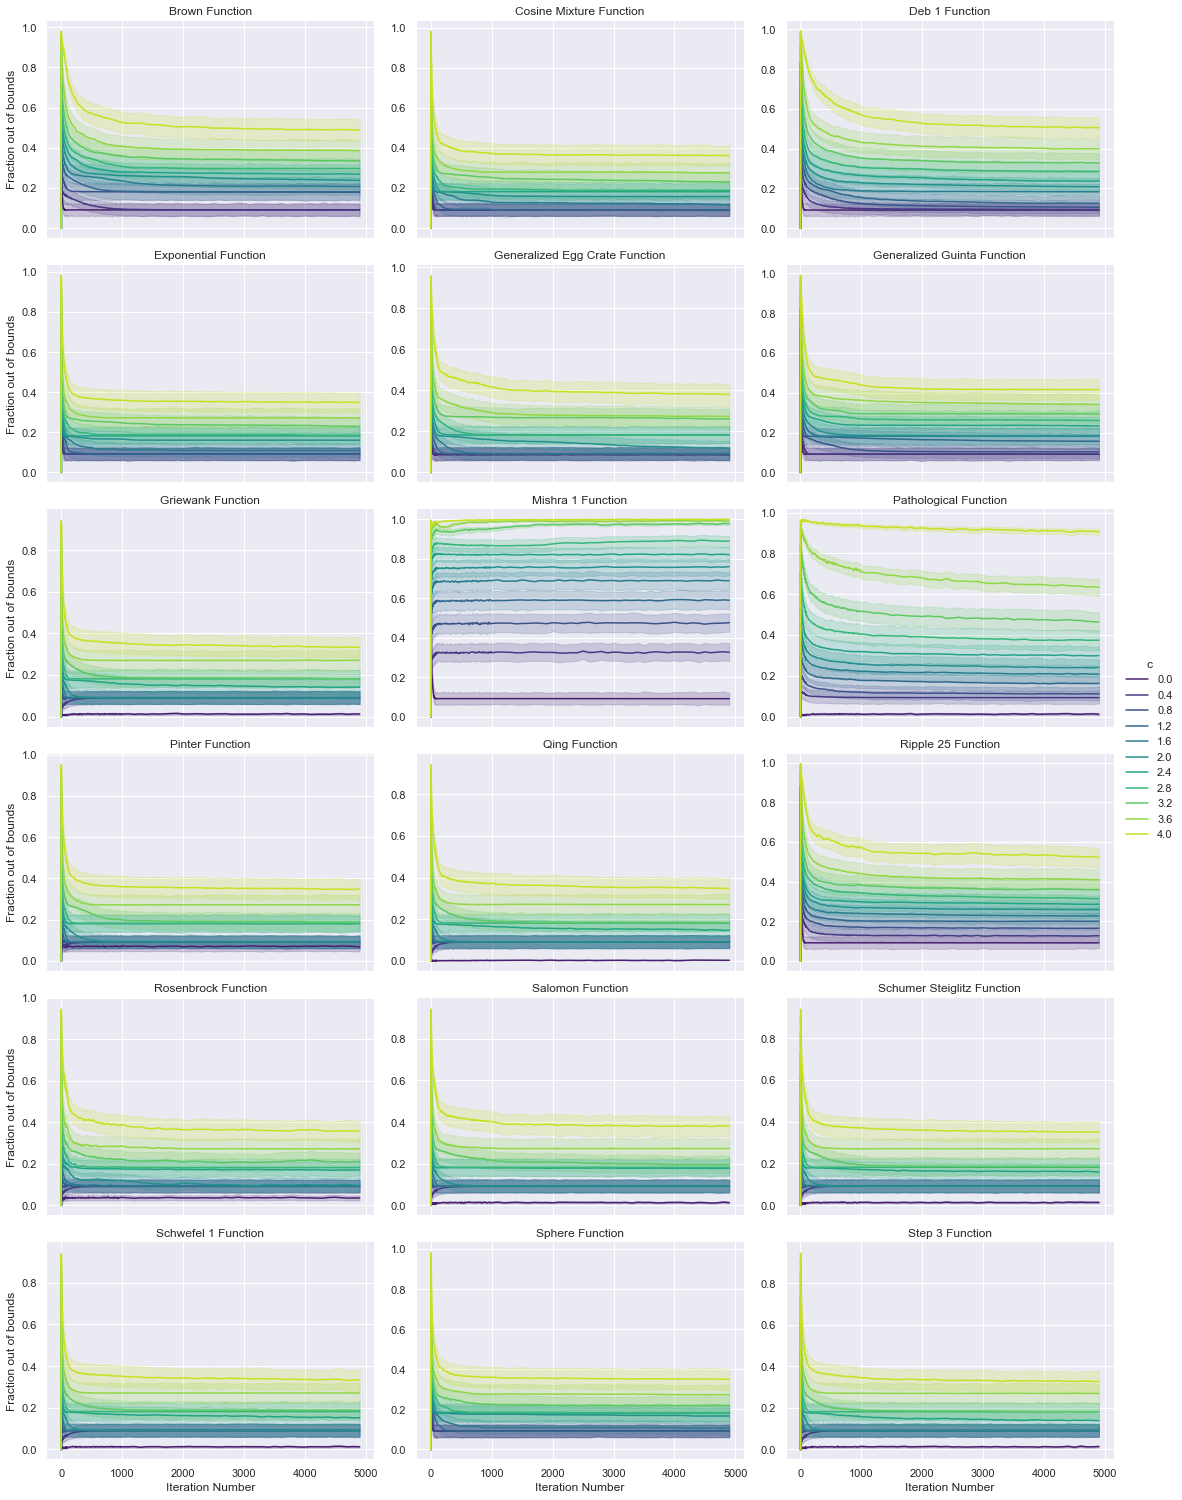

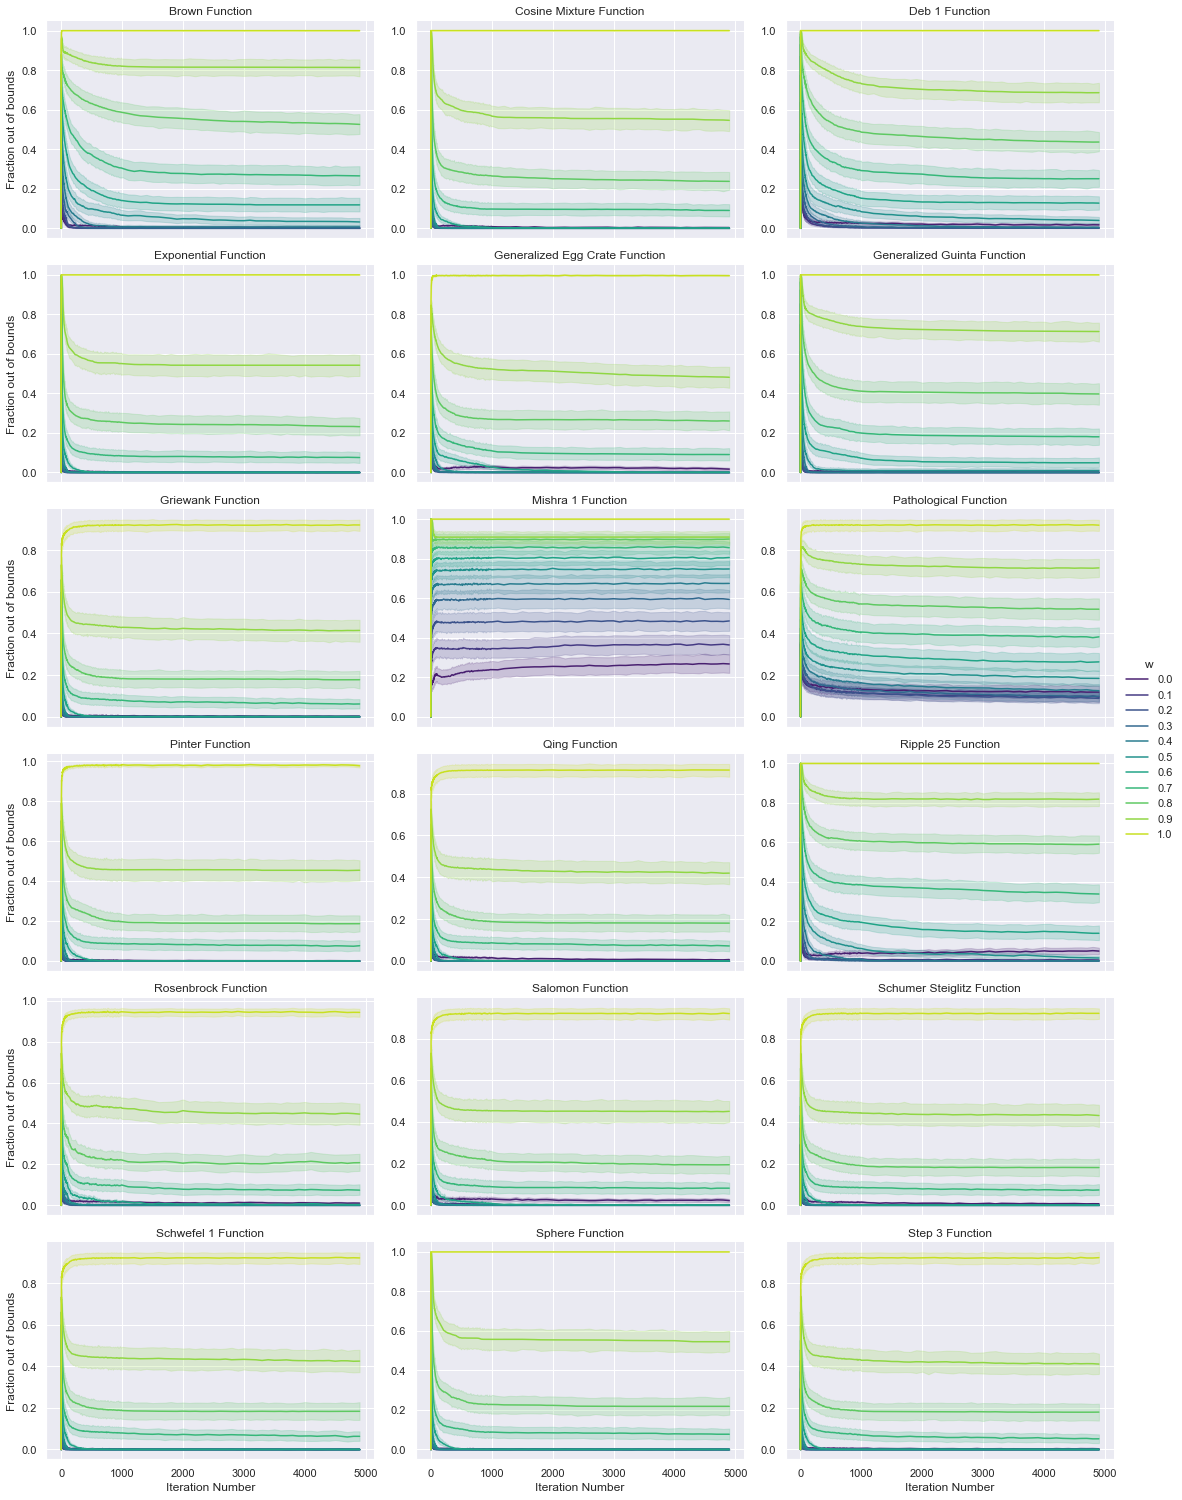

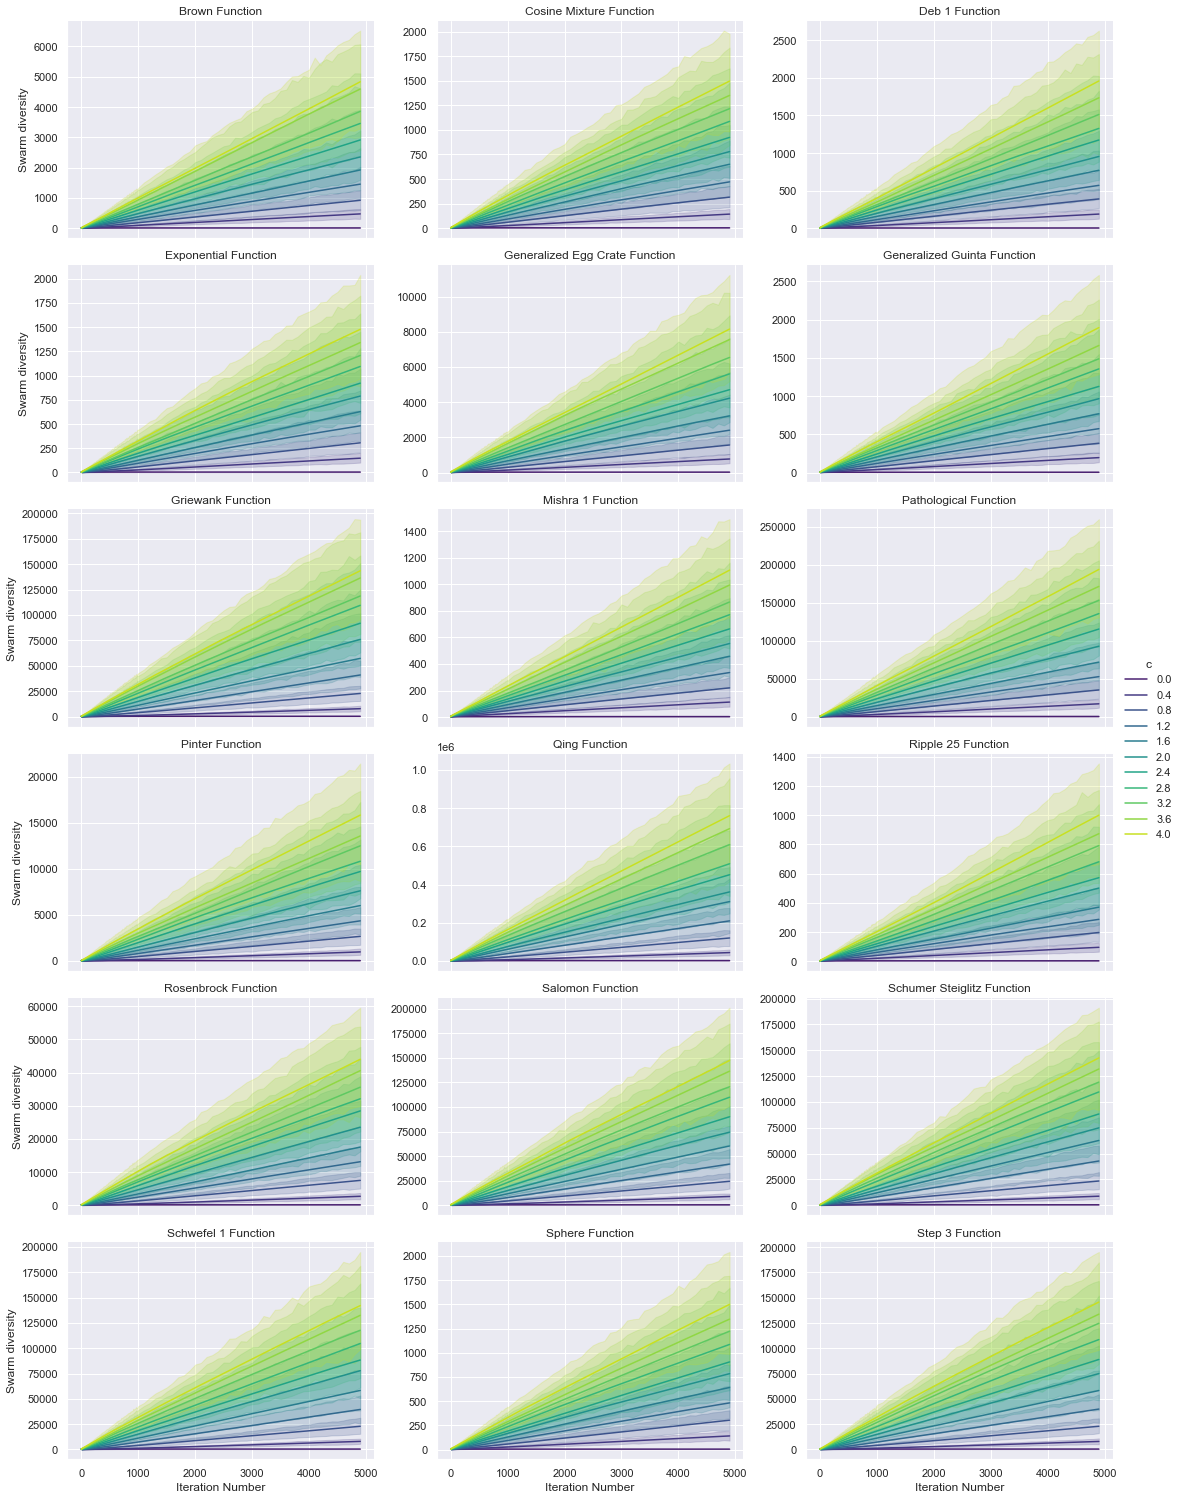

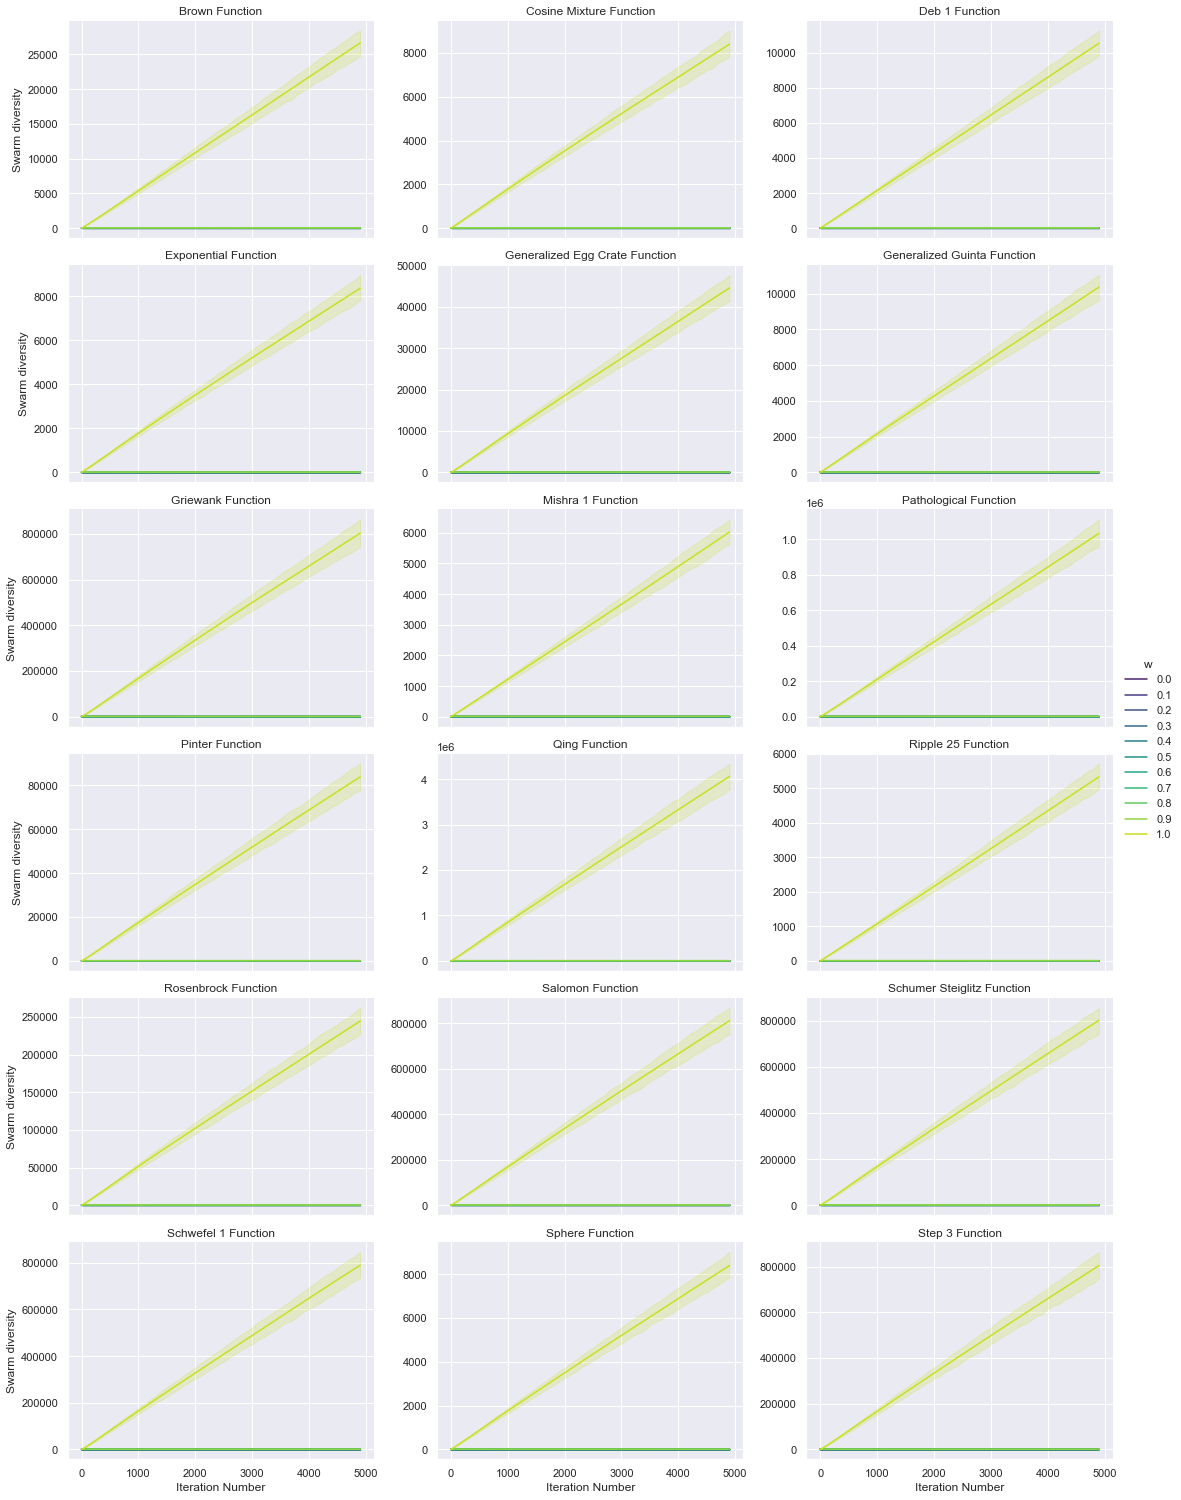

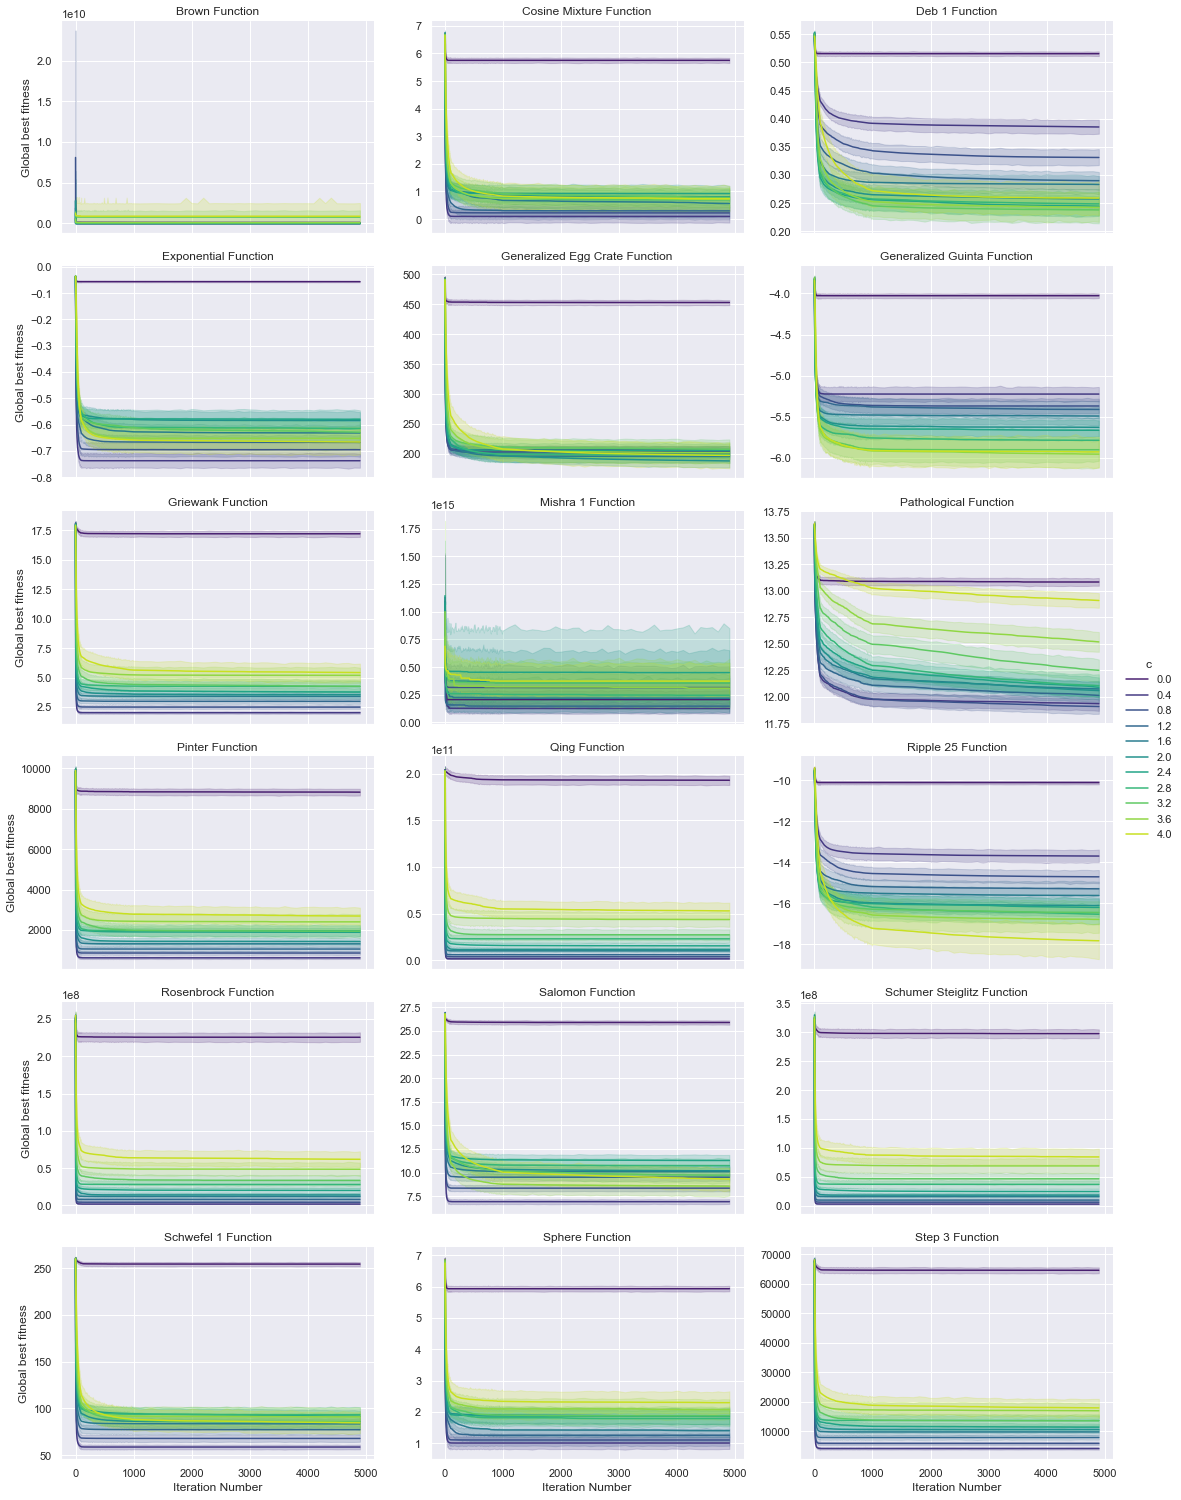

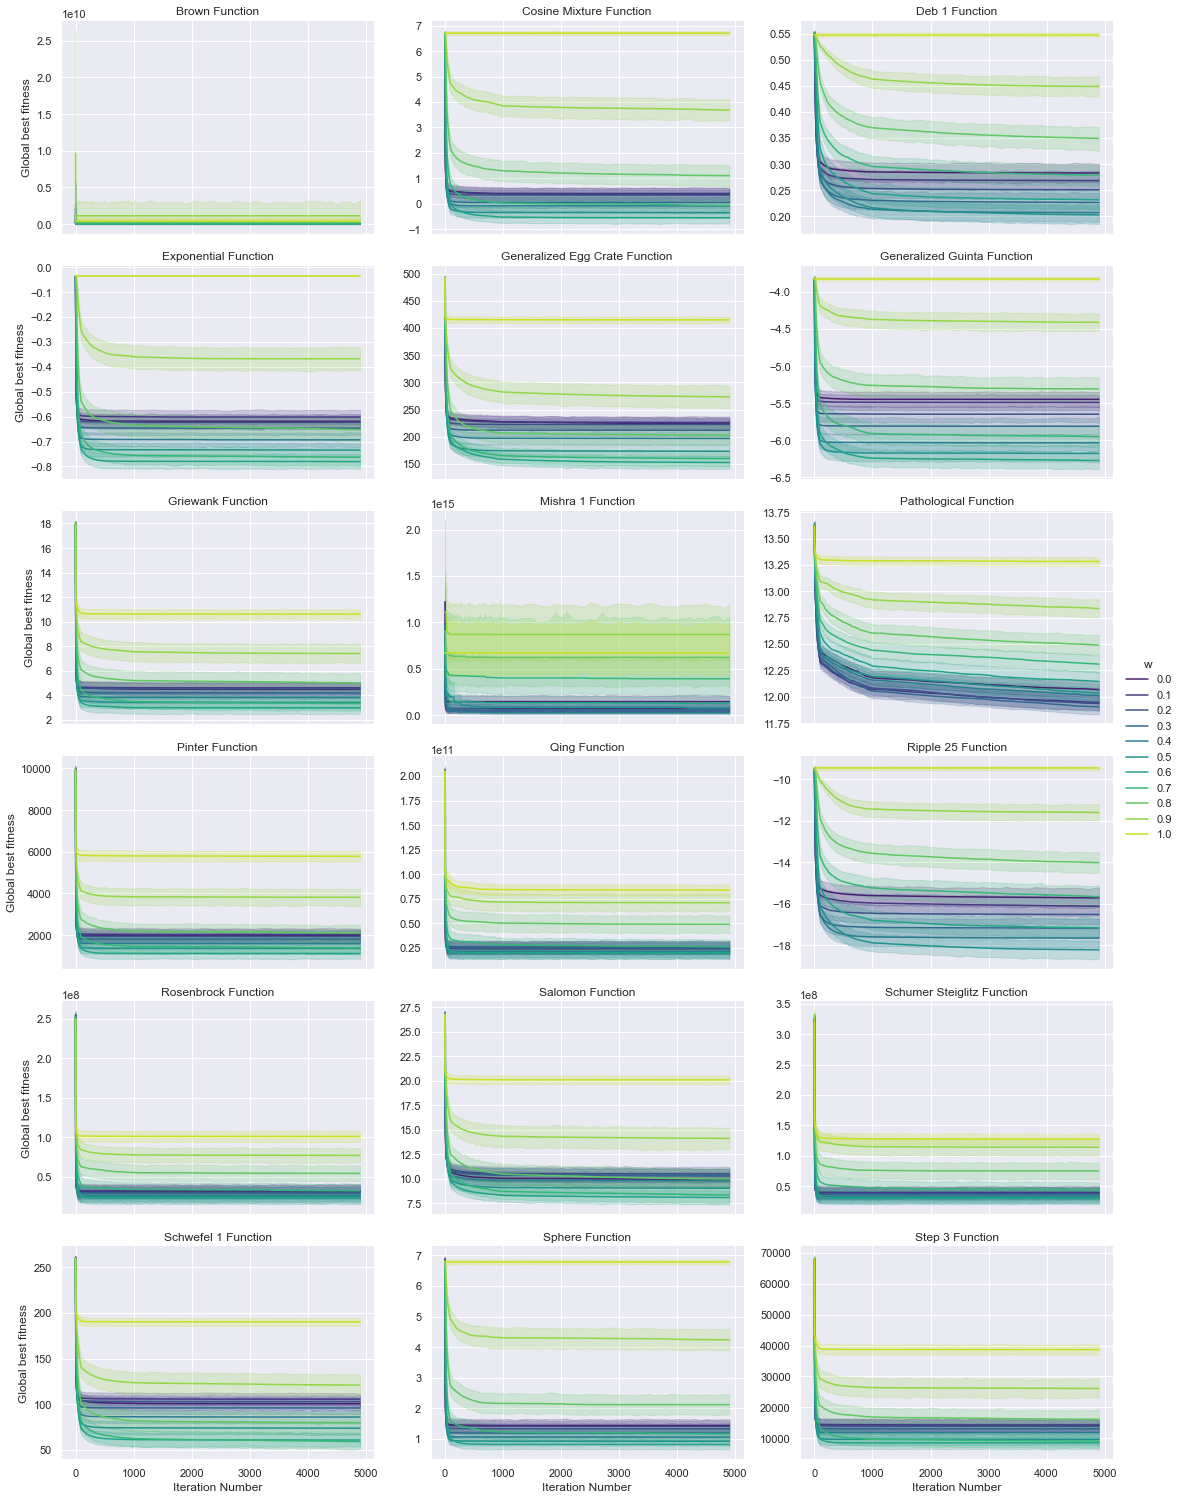

CPU times: user 39min 19s, sys: 30 s, total: 39min 49s
Wall time: 39min 57s


In [9]:
%%time
# CPU times: user 39min 4s, sys: 26.2 s, total: 39min 30s
# Wall time: 39min 31s
# start at 10h35

prefs = [
    {
        'key': 'perc_oob',
        'legend': 'c',
        'in_parens': 'Fraction out of bounds',
        'save_as': 'opt_perc_oob',
    }, {
        'key': 'gdiversity',
        'in_parens': 'Swarm diversity',
        'save_as': 'opt_gdiversity',
    }, {
        'key': 'gbest_fit',
        'in_parens': 'Global best fitness',
        'save_as': 'opt_gbest_fitness',
    },
]
pref = prefs[2]
for pref in prefs:
#     opt = pd.read_csv(f'data/raw/opt_{datetime.date.today()}.csv')
    opt = pd.read_csv(f'data/raw/opt_2022-03-20.csv')
    opt = opt[~opt.benchmark.isin([
        'Deb 3 Function',
        'Generalized Price 2 Function',
        'Mishra 7 Function',
        'Generalized Paviani Function',
    ])].sort_values('benchmark')

    opt['c'] = np.round(opt['c1'] + opt['c2'], 4)
    opt['w'] = np.round(opt['w'], 4)

    for param in ['c', 'w']:
        opt_ot = opt.groupby(['benchmark', 'w', 'c', 'iter_num']) \
            .gbest_fit.mean() \
            .reset_index() \
            .sort_values('benchmark')

        g = sns.FacetGrid(
            data=opt, 
            col="benchmark",
            hue=param,
            col_wrap=3,
            height=3.5, 
            aspect=1.5,
            sharey=False,
            palette="viridis"
        )
        g.map(
            sns.lineplot, 
            "iter_num", 
            pref['key'],
        #     ci=None
        )
        g.add_legend()
        g.set_titles(
            col_template="{col_name}",
        )
        g.set_axis_labels("Iteration Number", pref['in_parens'])
        plt.savefig(f"../report/figs/{pref['save_as']}_{param}.pdf")
        plt.show()

# Resample from Poli

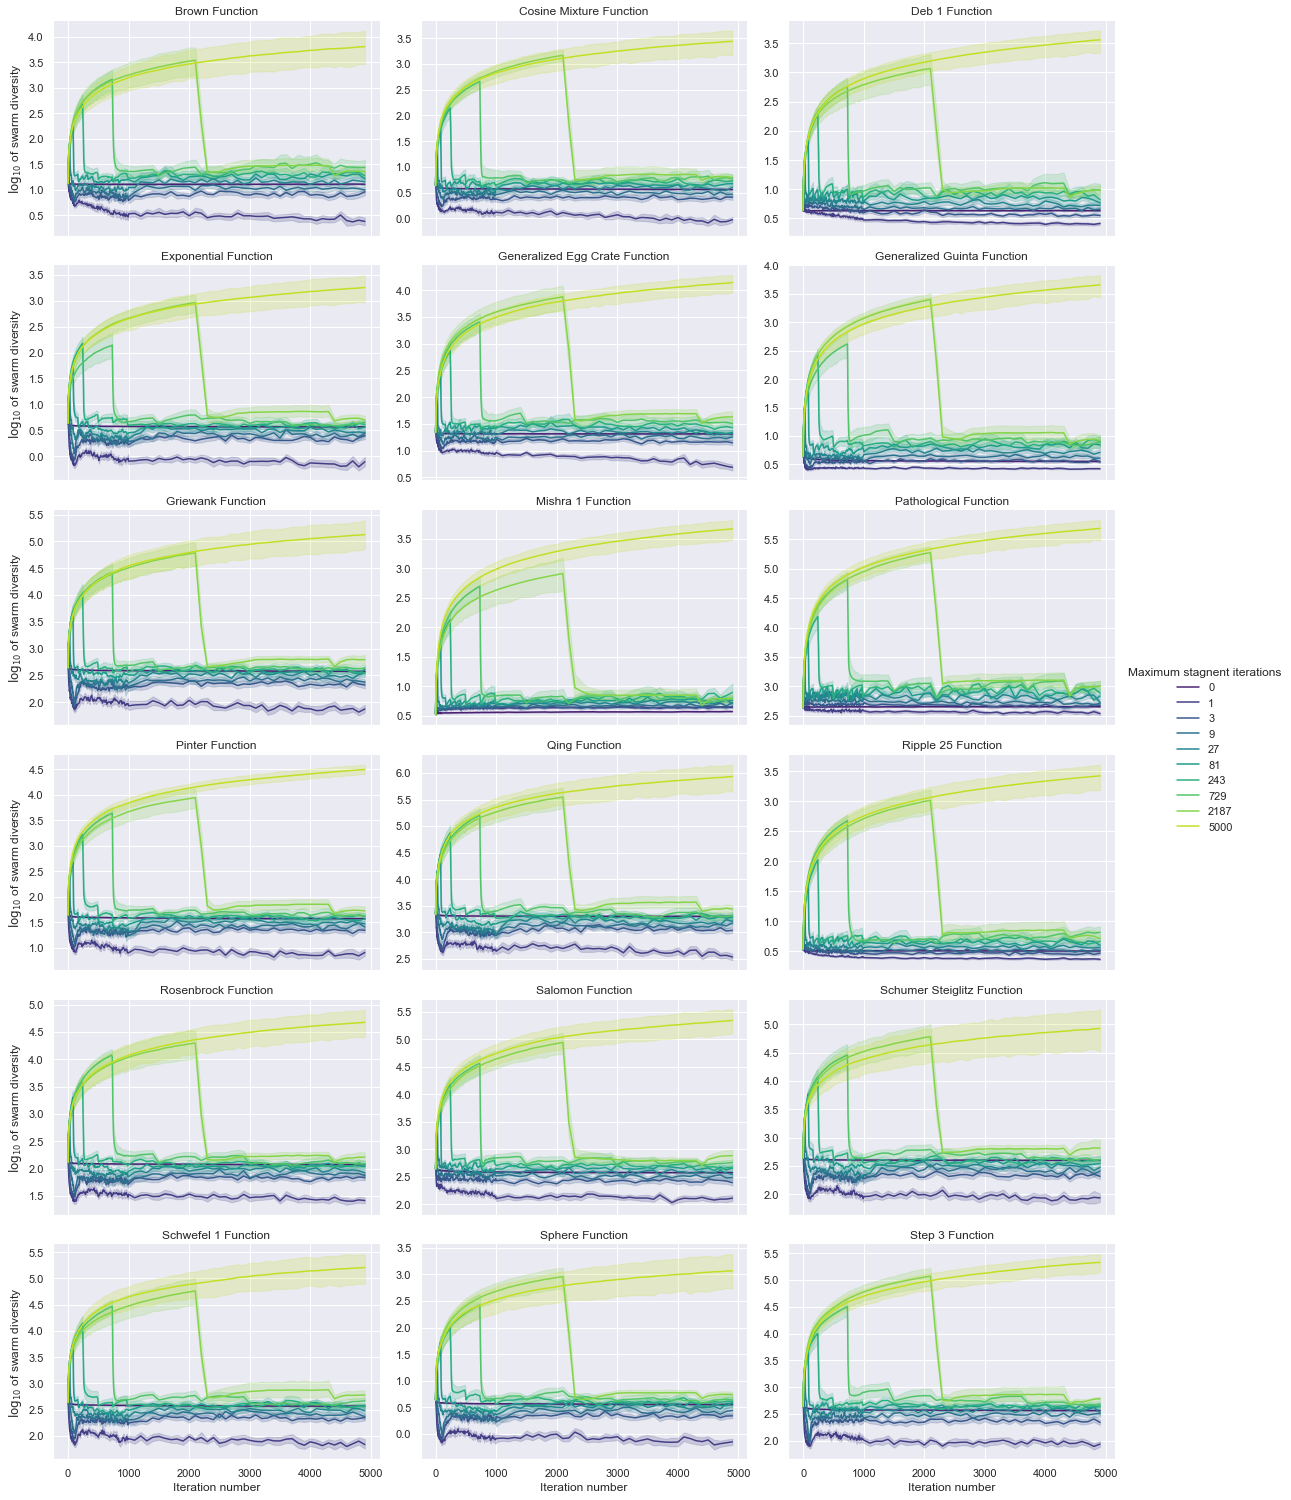

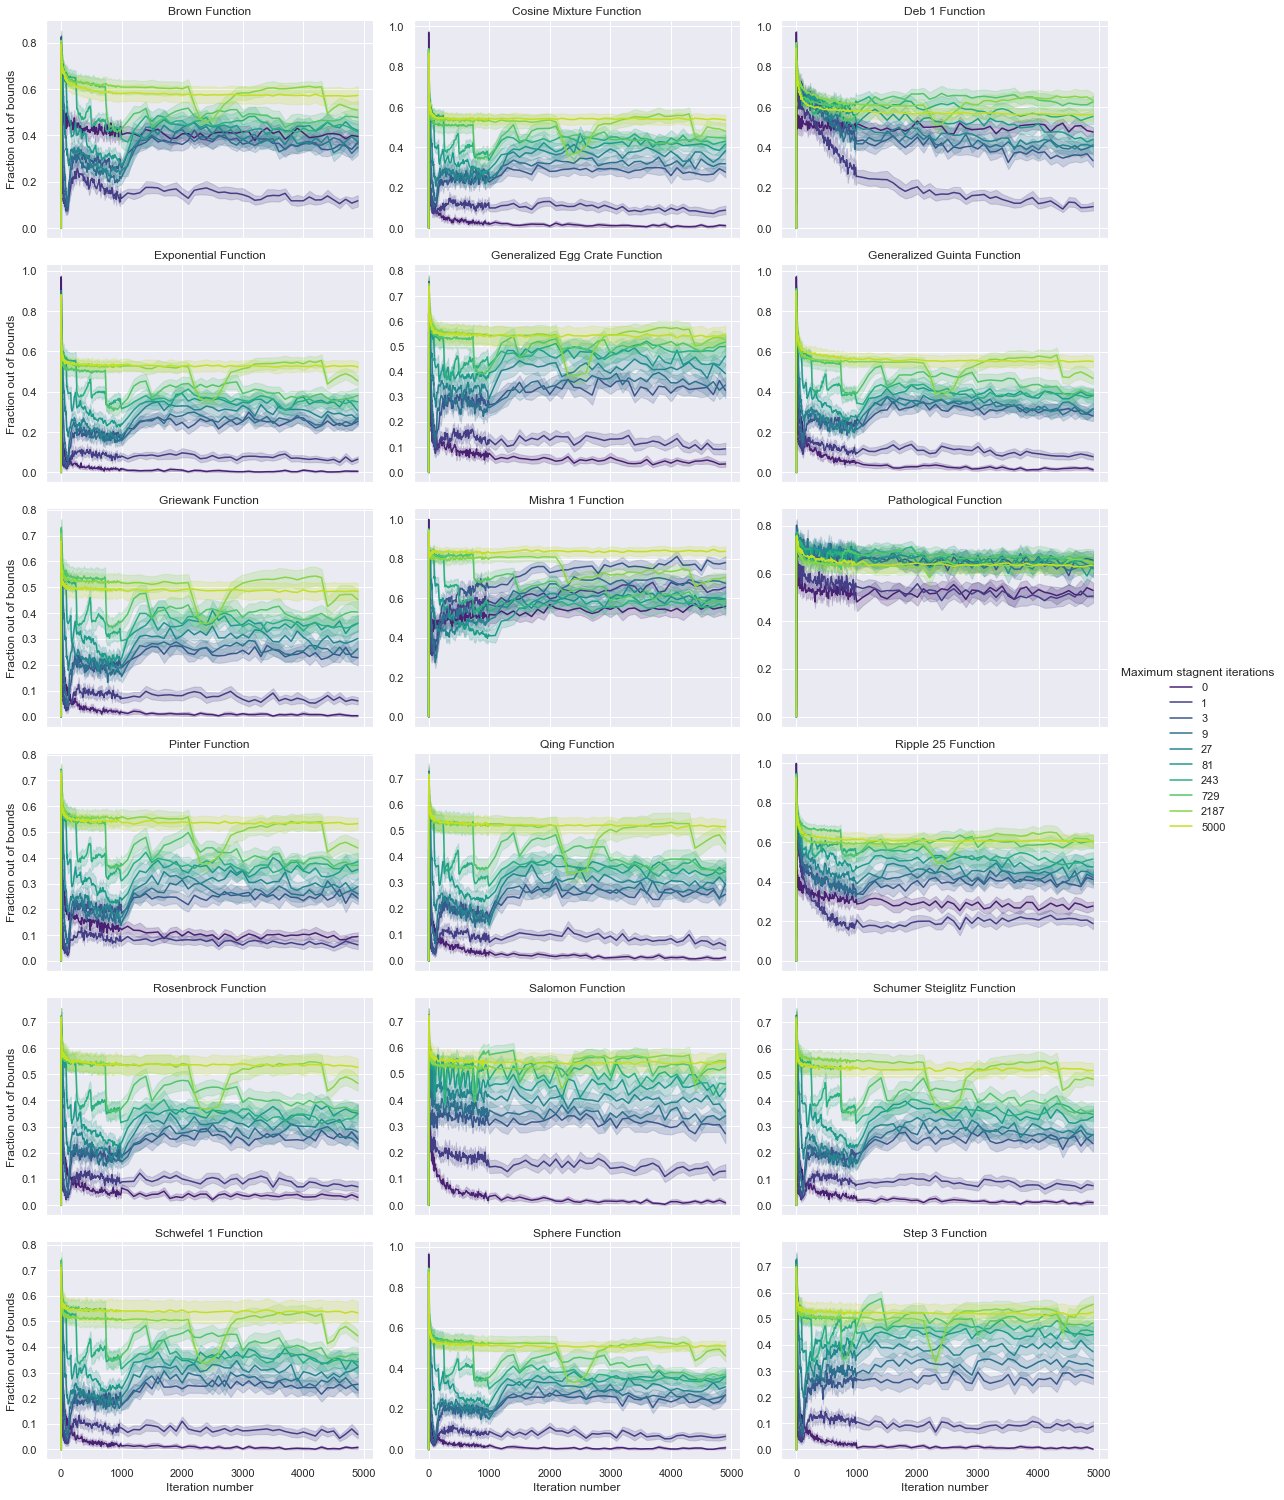

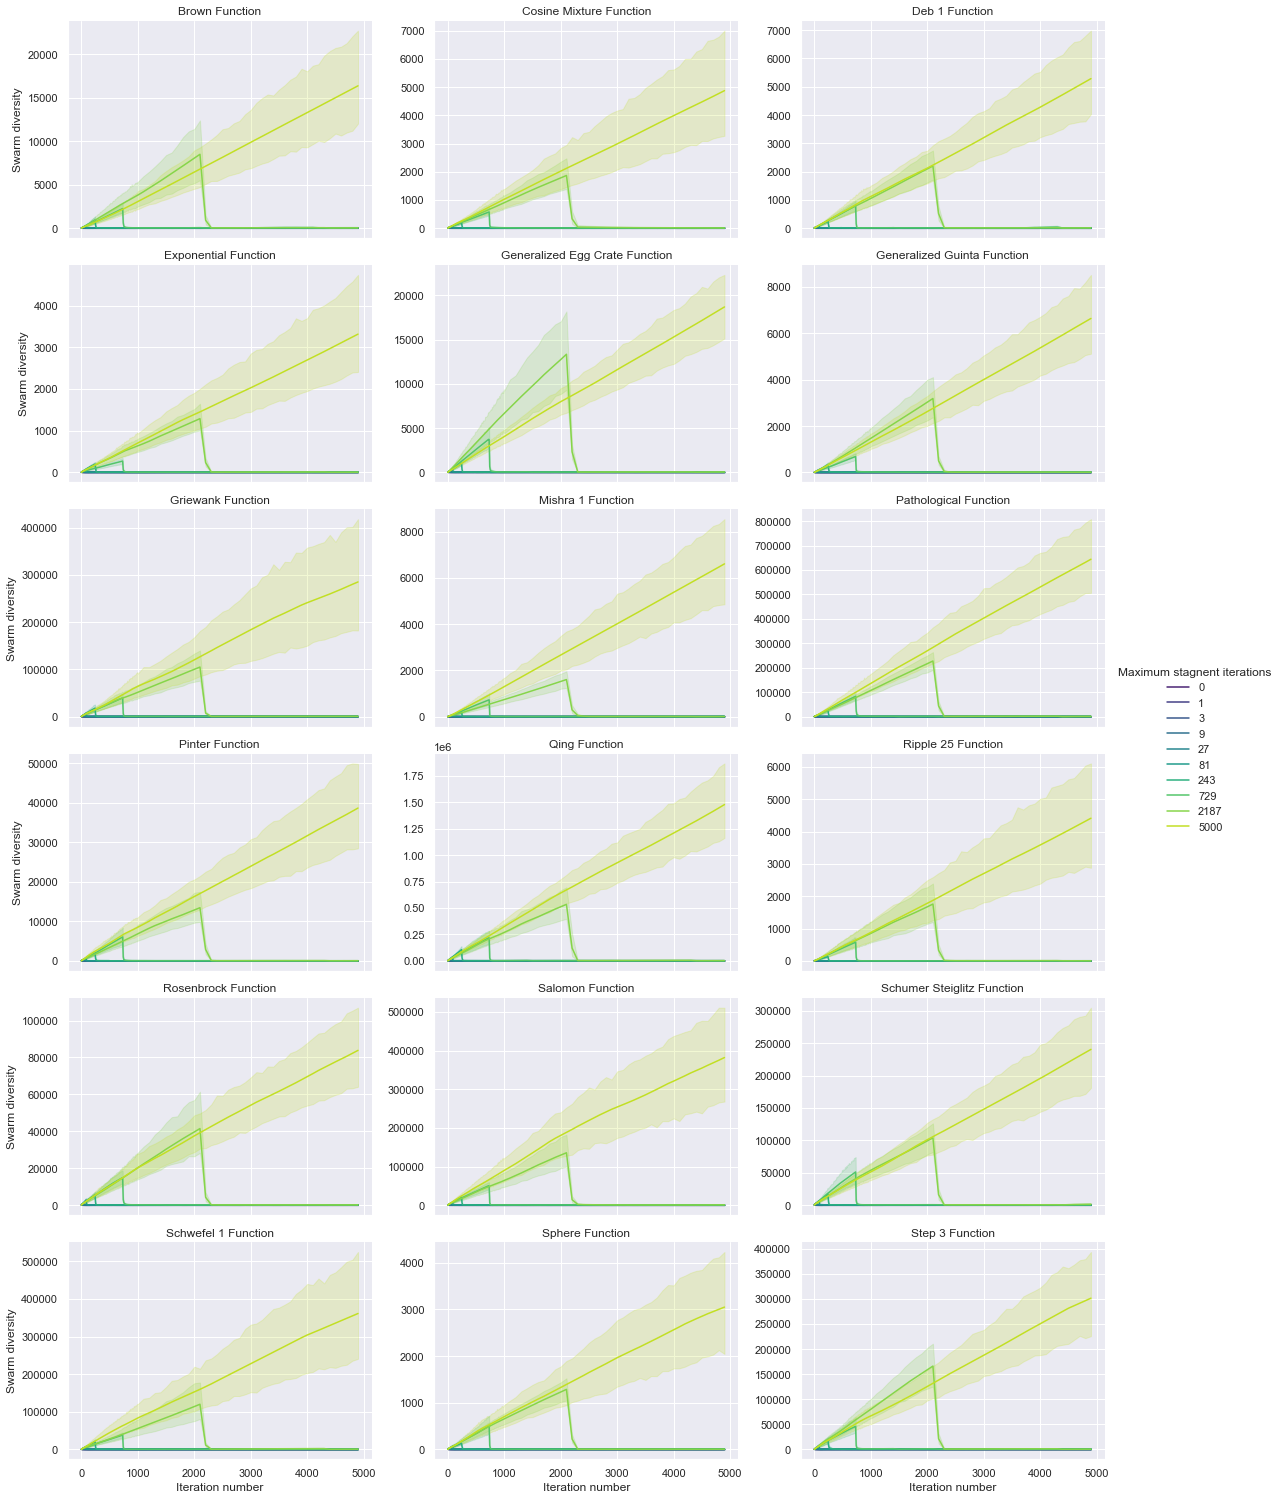

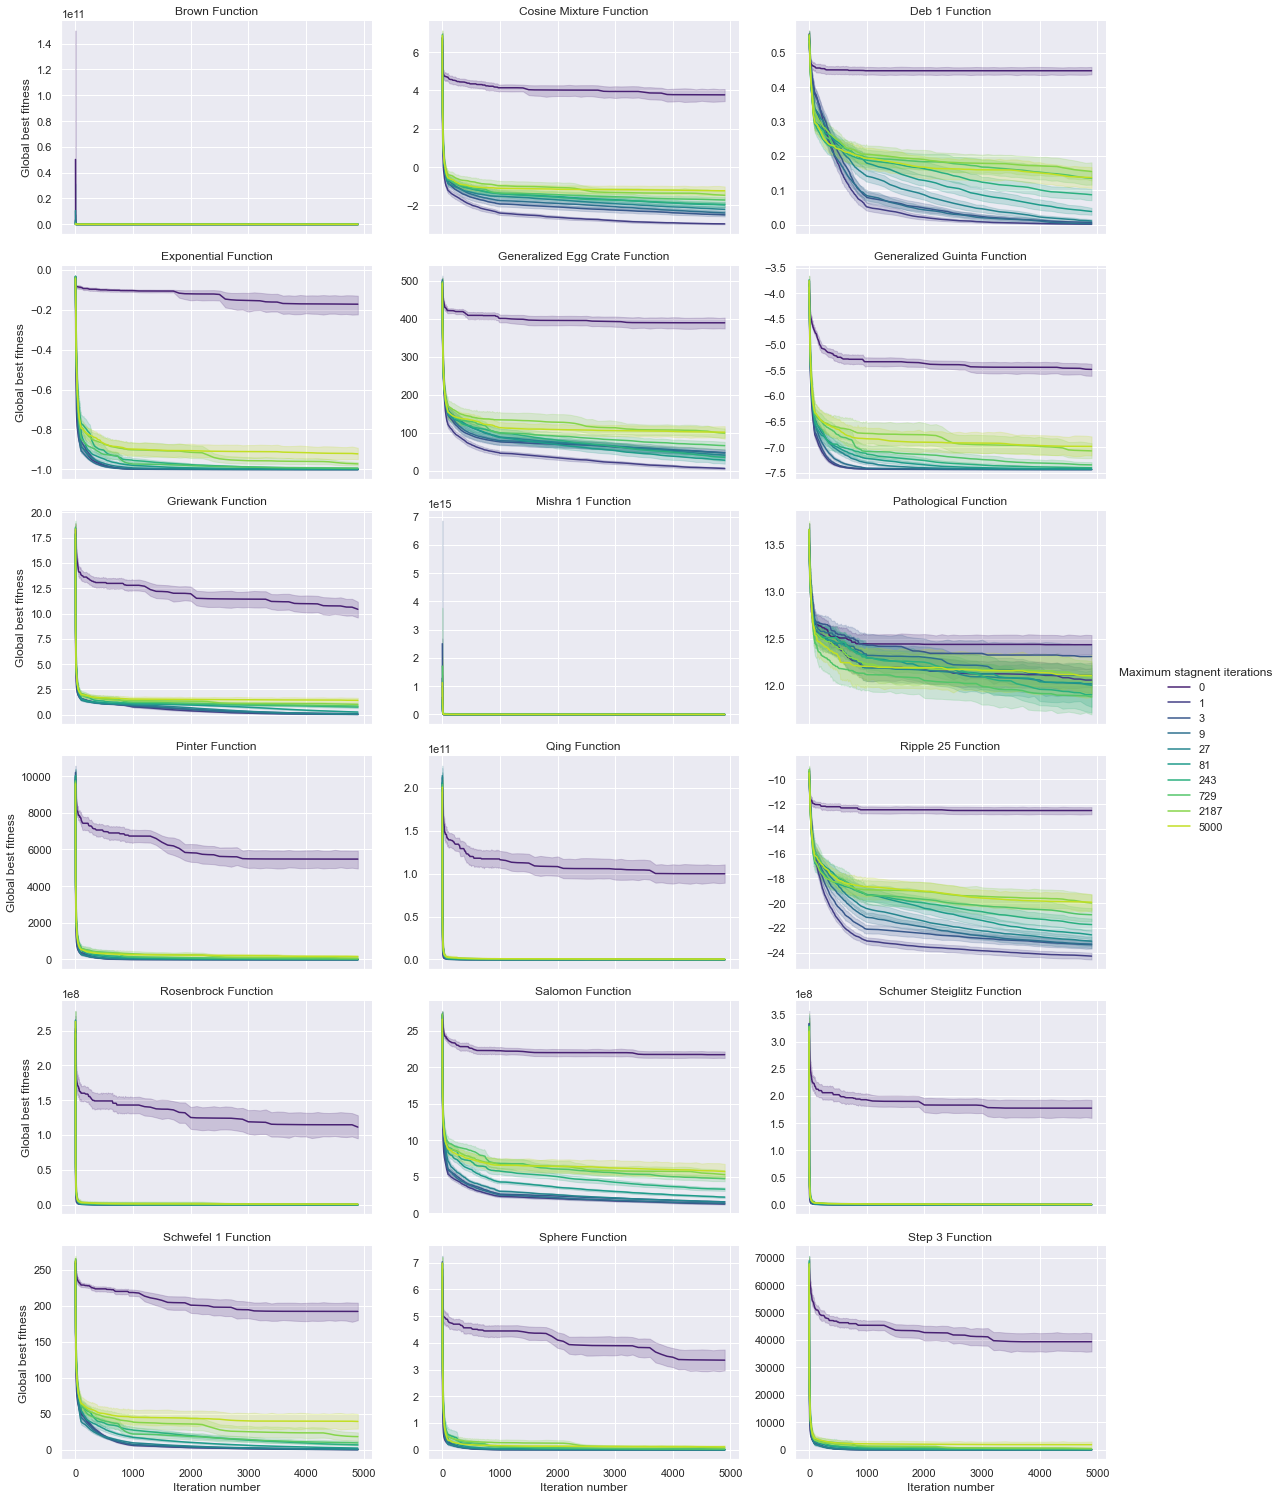

CPU times: user 17min 32s, sys: 3.6 s, total: 17min 35s
Wall time: 17min 35s


In [14]:
%%time
# CPU times: user 13min 22s, sys: 3.66 s, total: 13min 26s
# Wall time: 13min 25s
prefs = [
    {
        'key': 'log_diversity',
        'in_parens': '$\log_{{10}}$ of swarm diversity',
        'save_as': 'resample_log_diversity_max_stagnent_iters',
    }, {
        'key': 'perc_oob',
        'in_parens': 'Fraction out of bounds',
        'save_as': 'resample_perc_oob_max_stagnent_iters',
    }, {
        'key': 'gdiversity',
        'in_parens': 'Swarm diversity',
        'save_as': 'resample_gdiversity_max_stagnent_iters',
    }, {
        'key': 'gbest_fit',
        'in_parens': 'Global best fitness',
        'save_as': 'resample_gbest_fit_max_stagnent_iters',
    },
]
pref = prefs[0]
for pref in prefs:
#     res = pd.read_csv(f'data/raw/resample_{datetime.date.today()}.csv').sort_values('benchmark')
    res = pd.read_csv(f'data/raw/resample_2022-03-20.csv').sort_values('benchmark')
    res = res[~res.benchmark.isin([
        'Deb 3 Function',
        'Generalized Price 2 Function',
        'Mishra 7 Function',
        'Generalized Paviani Function',
    ])]
    res['log_diversity'] = np.log10(res['gdiversity'])

    g = sns.FacetGrid(
        data=res, 
        col="benchmark",
        hue='max_stagnent_iters',
        col_wrap=3,
        height=3.5, 
        aspect=1.5,
        sharey=False,
        palette="viridis" # Different colour pallete to distinguish colours better
    )
    g.map(
        sns.lineplot, 
        "iter_num", pref['key'],
    #     ci=None,
    )
    g.add_legend(title='Maximum stagnent iterations')
    g.set_titles(
        col_template=f"{{col_name}}", 
    )
    g.set_axis_labels("Iteration number", pref['in_parens'])

    plt.savefig(f"../report/figs/{pref['save_as']}.pdf")
    plt.show()